In [34]:
from sqlalchemy import create_engine, text, inspect
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [35]:
# Variables globales
engine = None

def connect_to_db():
    global engine
    user = 'root'
    password = 'rootpassword'
    host = '127.0.0.1'
    port = 3309
    db = 'AIRQUALITY'

    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(connection_string)
    print("✅ Conexión a MySQL creada.")


In [36]:
def plot_correlation_map(df, cols=None, order=None, cmap="coolwarm", annot=True, figsize=(8,6)):
    """
    Grafica un mapa de correlación para un subconjunto de columnas de un DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    cols : list[str], opcional
        Lista de columnas a incluir en el mapa de correlación.
        Si None, se usan todas las columnas numéricas.
    order : list[str], opcional
        Orden específico de las columnas en el mapa.
    cmap : str, opcional
        Paleta de colores (ej: "coolwarm", "viridis", "mako", "RdBu").
    annot : bool, opcional
        Si True, muestra los valores numéricos de la correlación.
    figsize : tuple, opcional
        Tamaño de la figura en pulgadas (ancho, alto).
    """
    # Selección de columnas
    if cols is not None:
        df_sel = df[cols]
    else:
        df_sel = df.select_dtypes(include="number")

    # Reordenamiento si se especifica
    if order is not None:
        df_sel = df_sel[order]

    # Calcular correlaciones
    corr = df_sel.corr()

    # Graficar
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=annot, cmap=cmap, center=0, linewidths=0.5, fmt=".2f")
    plt.title("Mapa de correlación", fontsize=14, pad=12)
    plt.show()


In [37]:
def load_resampled_dataframes_from_db():
    """
    Carga los datos desde las tablas resampleadas de la base de datos 
    y los devuelve como DataFrames de pandas.

    Retorna:
        tuple: (df_aq2, df_aq1, df_aqsep)
    """
    if engine is None:
        raise Exception("⚠️ Debes ejecutar primero `connect_to_db()` para establecer la conexión.")

    try:
        df_aq2 = pd.read_sql("SELECT * FROM DF_AQ2_RESAMPLED", con=engine, parse_dates=["time_format"])
        df_aq1 = pd.read_sql("SELECT * FROM DF_AQ1_RESAMPLED", con=engine, parse_dates=["time_format"])
        df_aqsep = pd.read_sql("SELECT * FROM DF_AQSEP_RESAMPLED", con=engine, parse_dates=["time_format"])

        # Asegurarse de que 'time_format' sea el índice si está presente
        for df in [df_aq2, df_aq1, df_aqsep]:
            if 'time_format' in df.columns:
                df.set_index('time_format', inplace=True)

        print("✅ Tablas resampleadas cargadas correctamente.")
        return df_aq2, df_aq1, df_aqsep

    except Exception as e:
        print(f"❌ Error al cargar las tablas resampleadas: {e}")
        return None, None, None


In [38]:
# Ejecutar primero conexión
connect_to_db()
# Cargar los DataFrames desde MySQL
DF_AQ2, DF_AQ1, DF_AQSEP = load_resampled_dataframes_from_db()

✅ Conexión a MySQL creada.
✅ Tablas resampleadas cargadas correctamente.


In [39]:
print(DF_AQ2.head())
print(DF_AQ1.head())
print(DF_AQSEP.head())

                     pm2_5  pm10    co   o3  humidity  temperature  pm5
time_format                                                            
2023-06-28 00:00:00   13.0  22.5  15.5  0.0     81.30         11.1  6.0
2023-06-28 01:00:00   10.0  13.0  12.5  0.0     83.95         10.9  5.0
2023-06-28 02:00:00   11.0  13.0  14.0  0.0     83.70         10.4  6.0
2023-06-28 03:00:00   13.0  21.0  17.0  0.0     85.80         10.4  6.0
2023-06-28 04:00:00   17.0  24.0  16.0  0.0     85.60         10.1  9.0
                     pm2_5  pm10    co   o3  humidity  temperature   pm5
time_format                                                             
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.2         11.6   5.0
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5   9.0
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0   8.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7  10.0
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3     

In [41]:
def filter_dataframe_by_date_range(df, start_date, end_date, plot=True):
    """
    Filtra un DataFrame por un rango de fechas y opcionalmente grafica todas las columnas numéricas.

    Parámetros:
        df (pd.DataFrame): DataFrame con índice datetime
        start_date (str): Fecha de inicio (formato 'YYYY-MM-DD HH:MM:SS')
        end_date (str): Fecha de fin (formato 'YYYY-MM-DD HH:MM:SS')
        plot (bool): Si True, genera el gráfico de todas las columnas numéricas

    Retorna:
        pd.DataFrame: DataFrame filtrado por fechas
    """
    # Copiar y asegurar que el índice sea datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Filtrar por fechas
    filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

    # Si se solicita, graficar todas las columnas numéricas
    if plot:
        numeric_cols = filtered_df.select_dtypes(include='number').columns

        if numeric_cols.empty:
            print("⚠️ No hay columnas numéricas para graficar.")
        else:
            plt.figure(figsize=(14, 6))
            filtered_df[numeric_cols].plot(kind='line', figsize=(14, 6))
            plt.title(f'Variables numéricas desde {start_date} hasta {end_date}', fontsize=14)
            plt.xlabel('Fecha y hora', fontsize=12)
            plt.ylabel('Valores', fontsize=12)
            plt.legend(title='Variables')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    return filtered_df


In [43]:
DF_AQ1.count()

pm2_5          9068
pm10           9068
co             8368
o3              790
humidity       9066
temperature    9035
pm5            9068
dtype: int64

In [44]:
DF_AQ1_F = filter_dataframe_by_date_range(DF_AQ1, '2023-08-01 00:00:00', '2024-03-13 00:00:00', plot=False)
DF_AQ2_F = filter_dataframe_by_date_range(DF_AQ2, '2023-08-01 00:00:00', '2024-03-13 00:00:00', plot=False)
DF_AQSEP_F = filter_dataframe_by_date_range(DF_AQSEP, '2023-08-01 00:00:00', '2024-03-13 00:00:00', plot=False)

In [45]:
DF_AQ1_F.count()

pm2_5          5279
pm10           5279
co             4579
o3               12
humidity       5277
temperature    5256
pm5            5279
dtype: int64

In [46]:
DF_AQ1_F.isna().sum()

pm2_5           122
pm10            122
co              822
o3             5389
humidity        124
temperature     145
pm5             122
dtype: int64

In [47]:
DF_AQ2_F.isna().sum()

pm2_5           124
pm10            125
co              124
o3             5389
humidity        125
temperature     125
pm5             125
dtype: int64

In [48]:
DF_AQSEP_F.isna().sum()

pm2_5           193
pm10            216
co              178
o3              140
pm5            5401
humidity        350
temperature     140
dtype: int64

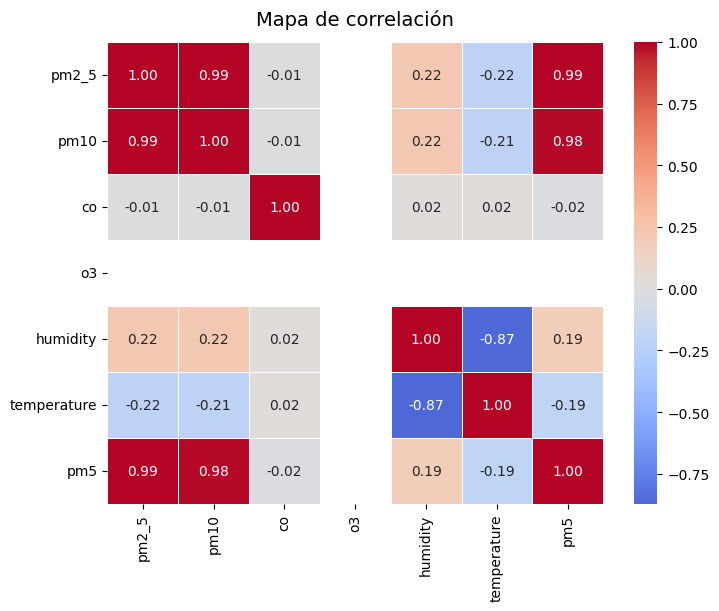

In [49]:
plot_correlation_map(DF_AQ1_F)

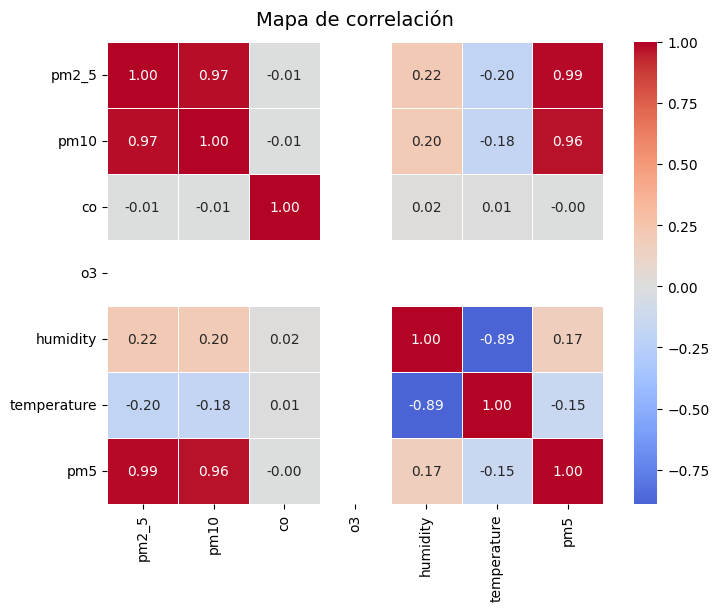

In [50]:
plot_correlation_map(DF_AQ2_F)

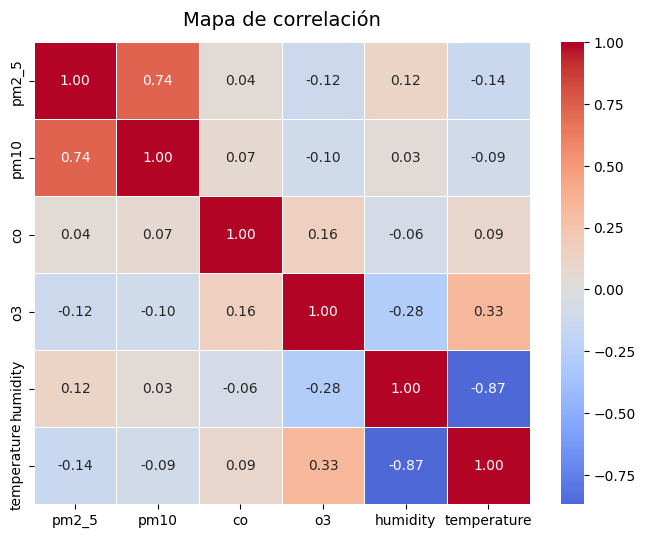

In [51]:
plot_correlation_map(DF_AQSEP_F)

In [52]:
#DF_AQ2_FC = DF_AQ2_F.drop(columns=['co', 'o3'])
#DF_AQ1_FC = DF_AQ1_F.drop(columns=['co', 'o3'])
#DF_AQSEP_FC = DF_AQSEP_F.drop(columns=['co', 'o3'])
DF_AQ2_FC = DF_AQ2_F.drop(columns=['o3','co'])
DF_AQ1_FC = DF_AQ1_F.drop(columns=['o3','co'])
DF_AQSEP_FC = DF_AQSEP_F.drop(columns=['o3','co'])

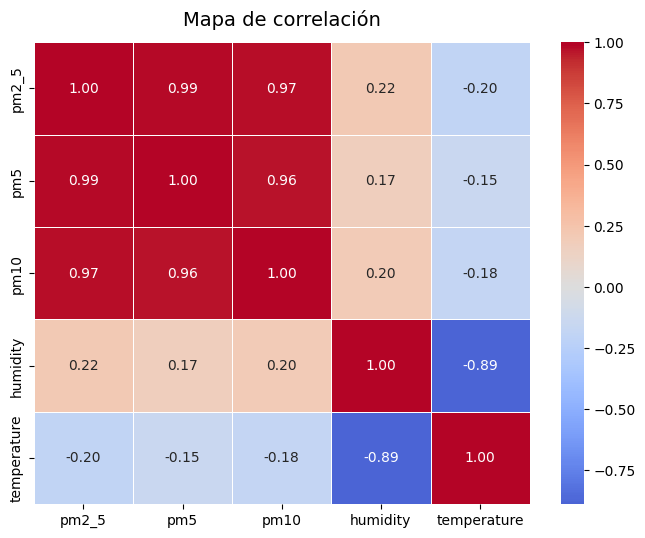

In [53]:
plot_correlation_map(DF_AQ2_FC,
    cols=["pm2_5", "pm10", "pm5", "humidity", "temperature"],
    order=["pm2_5", "pm5", "pm10", "humidity", "temperature"]
)

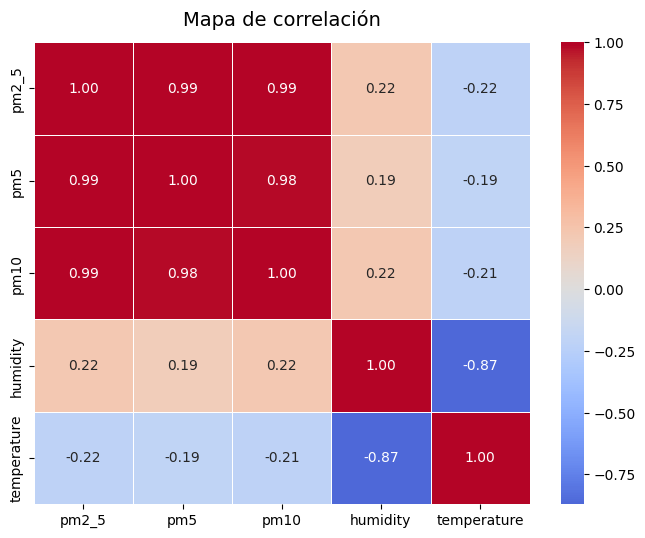

In [54]:
plot_correlation_map(DF_AQ1_FC,
    cols=["pm2_5", "pm10", "pm5", "humidity", "temperature"],
    order=["pm2_5", "pm5", "pm10", "humidity", "temperature"]
)

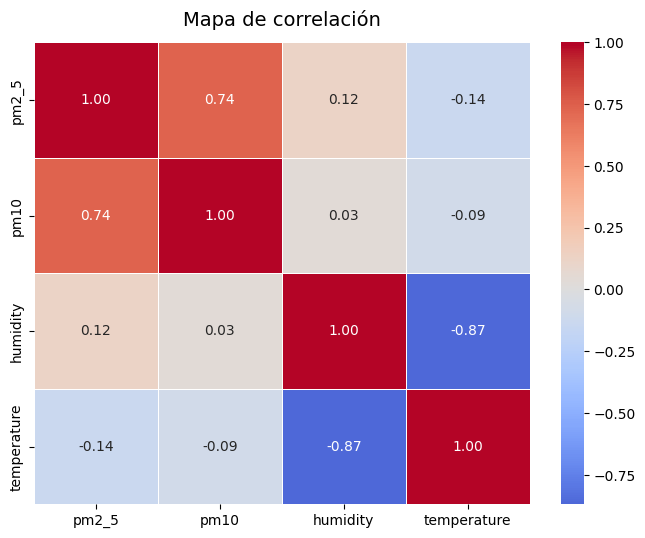

In [55]:
plot_correlation_map(DF_AQSEP_FC,
    cols=["pm2_5", "pm10", "humidity", "temperature"],
    order=["pm2_5", "pm10", "humidity", "temperature"]
)

In [56]:
def imputar_valores_sarima(df, columna='pm10', plot=True, 
                               order=(1,1,1), seasonal_order=(1,1,1,24)):
    """
    Función para imputar valores faltantes en datos de calidad del aire (PM10)
    utilizando el modelo SARIMA, con manejo mejorado de índices de tiempo.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con índice temporal y columna de PM10 con valores faltantes
    columna : str, default='pm10'
        Nombre de la columna que contiene los datos de PM10
    plot : bool, default=True
        Si se deben mostrar gráficos de los resultados
    order : tuple, default=(1,1,1)
        Orden del modelo SARIMA (p,d,q)
    seasonal_order : tuple, default=(1,1,1,24)
        Orden estacional del modelo SARIMA (P,D,Q,s) - default estacionalidad diaria
        
    Retorna:
    --------
    DataFrame con los valores imputados
    """
    # Crear una copia del DataFrame original
    df_imputado = df.copy()
    
    # Asegurarse de que el índice es datetime
    if not isinstance(df_imputado.index, pd.DatetimeIndex):
        print("ADVERTENCIA: El índice no es de tipo datetime. Se recomienda establecer un índice de tiempo.")
    
    # Verificar si hay valores faltantes
    if not df_imputado[columna].isna().any():
        print("No hay valores faltantes en la columna", columna)
        return df_imputado
    
    # Identificar posiciones de valores faltantes
    mask_nan = df_imputado[columna].isna()
    indices_nan = np.where(mask_nan)[0]
    print(f"Se encontraron {len(indices_nan)} valores faltantes")
    
    # Si todos los valores son NaN, no podemos hacer imputación con SARIMA
    if len(indices_nan) == len(df_imputado):
        raise ValueError("Todos los valores son NaN, no se puede realizar la imputación con SARIMA")
    
    # Encontrar secuencias de valores NaN consecutivos
    secuencias_nan = []
    secuencia_actual = []
    
    for i in range(len(indices_nan)):
        if i == 0 or indices_nan[i] != indices_nan[i-1] + 1:
            if secuencia_actual:
                secuencias_nan.append(secuencia_actual)
            secuencia_actual = [indices_nan[i]]
        else:
            secuencia_actual.append(indices_nan[i])
    
    if secuencia_actual:
        secuencias_nan.append(secuencia_actual)
    
    print(f"Usando parámetros SARIMA: {order} x {seasonal_order}")
    
    # Función para imputar una secuencia de valores faltantes
    def imputar_secuencia(indices):
        # Si es el primer valor en el índice, no podemos usar datos anteriores
        if indices[0] == 0:
            inicio_entrenamiento = indices[-1] + 1
            fin_entrenamiento = min(inicio_entrenamiento + 24*7, len(df_imputado) - 1)  # Usar 1 semana de datos si está disponible
            
            if inicio_entrenamiento >= len(df_imputado) or fin_entrenamiento >= len(df_imputado):
                # Si no hay datos después, usar la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores al inicio")
                return
            
            # Entrenar modelo con datos posteriores
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento+1][columna]
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Predecir valores anteriores - hacer forecast en dirección negativa
                # En lugar de usar predict con start/end, creamos manualmente predicciones
                predicciones = []
                for _ in range(len(indices)):
                    predicciones.insert(0, resultado.forecast(steps=1)[0])  # Insertamos al inicio
                
                # Imputar los valores predichos
                for i, idx in enumerate(indices):
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores al inicio: {e}")
                # Imputar con la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
        
        # Si es el último valor en el índice, no podemos usar datos posteriores
        elif indices[-1] == len(df_imputado) - 1:
            fin_entrenamiento = indices[0] - 1
            inicio_entrenamiento = max(0, fin_entrenamiento - 24*7)  # Usar 1 semana de datos si está disponible
            
            if inicio_entrenamiento < 0 or fin_entrenamiento < 0:
                # Si no hay datos antes, usar la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores al final")
                return
            
            # Entrenar modelo con datos anteriores
            train = df_imputado.iloc[inicio_entrenamiento:fin_entrenamiento+1][columna]
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Predecir valores futuros
                predicciones = resultado.forecast(steps=len(indices))
                
                # Imputar los valores predichos
                for i, idx in enumerate(indices):
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores al final: {e}")
                # Imputar con la media
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
        
        # Caso intermedio: hay datos antes y después
        else:
            # Identificar índices antes y después de la secuencia NaN
            indices_antes = list(range(0, indices[0]))
            indices_despues = list(range(indices[-1] + 1, len(df_imputado)))
            
            # Limitar a 7 días (168 horas) si hay suficientes datos
            if len(indices_antes) > 24*7:
                indices_antes = indices_antes[-24*7:]
            if len(indices_despues) > 24*7:
                indices_despues = indices_despues[:24*7]
            
            # Verificar si hay suficientes datos para entrenar
            if len(indices_antes) == 0 and len(indices_despues) == 0:
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores intermedios")
                return
            
            # Preparar datos de entrenamiento
            train_antes = df_imputado.iloc[indices_antes][columna].dropna() if indices_antes else pd.Series()
            train_despues = df_imputado.iloc[indices_despues][columna].dropna() if indices_despues else pd.Series()
            
            # Si alguno de los conjuntos de entrenamiento está vacío, usar el otro
            if len(train_antes) == 0:
                train = train_despues
            elif len(train_despues) == 0:
                train = train_antes
            else:
                train = pd.concat([train_antes, train_despues])
            
            # Si después de filtrar NaN no tenemos suficientes datos, usamos la media
            if len(train) < 5:  # Mínimo de puntos para ajuste razonable
                valor_medio = df_imputado[columna].mean()
                for idx in indices:
                    df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                print(f"Usando la media ({valor_medio}) para imputar valores (pocos datos)")
                return
            
            # Ajustar modelo SARIMA
            try:
                modelo = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                resultado = modelo.fit(disp=False)
                
                # Calcular valores para imputar usando interpolación entre los datos antes y después
                # Este método evita problemas con predict() y fechas
                if len(train_antes) > 0 and len(train_despues) > 0:
                    # Si tenemos datos antes y después, usamos una combinación de ambos
                    ultimo_antes = df_imputado.iloc[indices_antes[-1]][columna]
                    primero_despues = df_imputado.iloc[indices_despues[0]][columna]
                    
                    # Generamos valores intermedios
                    total_gap = len(indices) + 1
                    for i, idx in enumerate(indices):
                        # Peso que varía de 0 (cerca de antes) a 1 (cerca de después)
                        peso = (i + 1) / total_gap
                        valor_base = ultimo_antes * (1 - peso) + primero_despues * peso
                        
                        # Agregar predicción del modelo como factor de corrección
                        prediccion = resultado.forecast(steps=1)[0]  # Solo un paso
                        factor_correccion = prediccion / train.mean() if train.mean() != 0 else 1
                        
                        # Aplicar corrección limitada para evitar valores extremos
                        factor_correccion = max(0.5, min(1.5, factor_correccion))
                        
                        # Valor final
                        valor_imputado = valor_base * factor_correccion
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_imputado
                else:
                    # Si solo tenemos datos de un lado, generamos forecast
                    predicciones = resultado.forecast(steps=len(indices))
                    for i, idx in enumerate(indices):
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = predicciones[i]
            except Exception as e:
                print(f"Error al imputar valores intermedios: {e}")
                # Imputar con interpolación lineal simple
                if len(train_antes) > 0 and len(train_despues) > 0:
                    ultimo_antes = df_imputado.iloc[indices_antes[-1]][columna]
                    primero_despues = df_imputado.iloc[indices_despues[0]][columna]
                    total_gap = len(indices) + 1
                    for i, idx in enumerate(indices):
                        peso = (i + 1) / total_gap
                        valor_imputado = ultimo_antes * (1 - peso) + primero_despues * peso
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_imputado
                    print("Usando interpolación lineal para imputar valores intermedios")
                else:
                    # Si solo hay datos de un lado, usamos la media
                    valor_medio = df_imputado[columna].mean()
                    for idx in indices:
                        df_imputado.iloc[idx, df_imputado.columns.get_loc(columna)] = valor_medio
                    print(f"Usando la media ({valor_medio}) para imputar valores")
    
    # Imputar cada secuencia de valores faltantes
    for i, secuencia in enumerate(secuencias_nan):
        print(f"Imputando secuencia {i+1} de {len(secuencias_nan)} ({len(secuencia)} valores)")
        imputar_secuencia(secuencia)
    
    # Mostrar gráficos si se solicita
    if plot:
        plt.figure(figsize=(15, 7))
        # Graficar serie original con NaNs
        serie_original = df[columna].copy()
        plt.plot(serie_original, 'o-', alpha=0.3, label='Original (con NaNs)')
        
        # Graficar solo los valores originales no-NaN
        valores_validos = df[~df[columna].isna()]
        plt.plot(valores_validos.index, valores_validos[columna], 'o', alpha=0.7, 
                label='Valores originales')
        
        # Graficar valores imputados
        valores_imputados = df_imputado[mask_nan]
        plt.plot(valores_imputados.index, valores_imputados[columna], 'rx', markersize=8, 
                label='Valores imputados')
        
        # Graficar serie completa imputada
        plt.plot(df_imputado.index, df_imputado[columna], 'g-', alpha=0.5, 
                label='Serie imputada')
        
        plt.xlabel('Fecha')
        plt.ylabel(f'Valores de {columna}')
        plt.title(f'Imputación de valores faltantes en {columna} usando SARIMA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return df_imputado

In [57]:
# ====================================================================
# FUNCIÓN PRINCIPAL OPTIMIZADA PARA IMPUTACIÓN SARIMA CON VARIABLES EXÓGENAS
# ====================================================================

def imputar_valores_sarima_optimized(df, columna='pm10', plot=True, 
                                    auto_optimize=True, remove_outliers=True,
                                    order=None, seasonal_order=None,
                                    max_p=3, max_d=2, max_q=3, 
                                    max_P=2, max_D=1, max_Q=2, s=24,
                                    outlier_factor=1.5, evaluate_quality=True,
                                    exog=None):
    """
    Versión optimizada de la función de imputación SARIMA con mejoras técnicas y soporte para variables exógenas.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con índice temporal y columna con valores faltantes
    columna : str, default='pm10'
        Nombre de la columna que contiene los datos
    plot : bool, default=True
        Si se deben mostrar gráficos de los resultados
    auto_optimize : bool, default=True
        Si debe buscar automáticamente los mejores parámetros SARIMA
    remove_outliers : bool, default=True
        Si debe remover outliers antes de la imputación
    order : tuple, optional
        Orden del modelo SARIMA (p,d,q). Si None y auto_optimize=False, usa (2,1,1)
    seasonal_order : tuple, optional
        Orden estacional del modelo SARIMA (P,D,Q,s). Si None y auto_optimize=False, usa (1,1,1,24)
    max_p, max_d, max_q : int
        Valores máximos para grid search (solo si auto_optimize=True)
    max_P, max_D, max_Q : int
        Valores máximos estacionales para grid search (solo si auto_optimize=True)
    s : int, default=24
        Período estacional
    outlier_factor : float, default=1.5
        Factor para detección de outliers (1.5 conservador, 3.0 agresivo)
    evaluate_quality : bool, default=True
        Si debe evaluar la calidad de imputación
    exog : DataFrame or array-like, optional
        Variables exógenas (predictoras externas) que ayudan a explicar la variable objetivo.
        Debe tener el mismo índice temporal que df.
        Ejemplo: exog = df[['humidity', 'temperature']]
        
    Retorna:
    --------
    dict: Contiene DataFrame imputado y métricas de calidad
    """
    print(f"=== Imputación SARIMA Optimizada para {columna} ===")
    
    # Crear una copia del DataFrame original
    df_original = df.copy()
    df_work = df.copy()
    
    # Procesar variables exógenas si se proporcionan
    exog_work = None
    if exog is not None:
        if isinstance(exog, pd.DataFrame):
            exog_work = exog.copy()
            exog_columns = list(exog.columns)
            print(f"📊 Variables exógenas detectadas: {exog_columns}")
        else:
            # Convertir array a DataFrame si es necesario
            exog_work = pd.DataFrame(exog, index=df.index)
            exog_columns = [f'exog_{i}' for i in range(exog_work.shape[1])]
            exog_work.columns = exog_columns
            print(f"📊 Variables exógenas convertidas: {exog_columns}")
        
        # Verificar que los índices coincidan
        if not df_work.index.equals(exog_work.index):
            print("⚠️ ADVERTENCIA: Los índices de df y exog no coinciden exactamente")
            # Realinear índices
            exog_work = exog_work.reindex(df_work.index)
        
        # Verificar valores faltantes en variables exógenas
        exog_missing = exog_work.isna().sum()
        if exog_missing.any():
            print("📋 Valores faltantes en variables exógenas:")
            for col, missing in exog_missing.items():
                if missing > 0:
                    print(f"  {col}: {missing} valores faltantes")
    else:
        print("📊 Sin variables exógenas especificadas")
    
    # Asegurarse de que el índice es datetime
    if not isinstance(df_work.index, pd.DatetimeIndex):
        print("ADVERTENCIA: El índice no es de tipo datetime.")
    
    # Verificar si hay valores faltantes
    if not df_work[columna].isna().any():
        print(f"No hay valores faltantes en la columna {columna}")
        return {'df_imputado': df_work, 'metricas': {'note': 'Sin valores faltantes'}}
    
    # Mostrar estadísticas iniciales
    total_values = len(df_work)
    missing_values = df_work[columna].isna().sum()
    missing_percentage = (missing_values / total_values) * 100
    
    print(f"Total de valores: {total_values}")
    print(f"Valores faltantes: {missing_values} ({missing_percentage:.1f}%)")
    
    # Si todos los valores son NaN, no podemos hacer imputación
    if missing_values == total_values:
        raise ValueError("Todos los valores son NaN, no se puede realizar la imputación")
    
    # Paso 1: Remover outliers si se solicita
    outliers_removed = 0
    if remove_outliers:
        print("\\n--- Paso 1: Detección y remoción de outliers ---")
        original_missing = df_work[columna].isna().sum()
        df_work[columna] = remove_outliers_iqr(df_work[columna], factor=outlier_factor)
        new_missing = df_work[columna].isna().sum()
        outliers_removed = new_missing - original_missing
        if outliers_removed > 0:
            print(f"Outliers convertidos a NaN: {outliers_removed}")
    
    # Paso 2: Análisis de estacionariedad
    print("\\n--- Paso 2: Análisis de estacionariedad ---")
    stationarity_result = test_stationarity(df_work[columna])
    print(f"Resultado del test ADF: {stationarity_result['note']}")
    print(f"p-value: {stationarity_result['p_value']:.4f}")
    
    # Paso 3: Optimización de parámetros
    if auto_optimize:
        print("\\n--- Paso 3: Optimización automática de parámetros ---")
        param_results = find_optimal_sarima_params_with_exog(
            df_work[columna], exog_work,
            max_p=max_p, max_d=max_d, max_q=max_q,
            max_P=max_P, max_D=max_D, max_Q=max_Q, 
            s=s
        )
        best_order = param_results['order']
        best_seasonal_order = param_results['seasonal_order']
        print(f"Parámetros óptimos: {best_order} x {best_seasonal_order}")
        if exog_work is not None:
            print(f"Con variables exógenas: {exog_columns}")
    else:
        # Usar parámetros proporcionados o por defecto
        best_order = order if order is not None else (2, 1, 1)
        best_seasonal_order = seasonal_order if seasonal_order is not None else (1, 1, 1, s)
        print(f"\\n--- Paso 3: Usando parámetros especificados ---")
        print(f"Parámetros: {best_order} x {best_seasonal_order}")
        if exog_work is not None:
            print(f"Con variables exógenas: {exog_columns}")
    
    # Paso 4: Imputación usando los parámetros optimizados
    print("\\n--- Paso 4: Imputación de valores ---")
    
    # Identificar posiciones de valores faltantes
    mask_nan = df_work[columna].isna()
    indices_nan = np.where(mask_nan)[0]
    
    # Encontrar secuencias de valores NaN consecutivos
    secuencias_nan = []
    secuencia_actual = []
    
    for i in range(len(indices_nan)):
        if i == 0 or indices_nan[i] != indices_nan[i-1] + 1:
            if secuencia_actual:
                secuencias_nan.append(secuencia_actual)
            secuencia_actual = [indices_nan[i]]
        else:
            secuencia_actual.append(indices_nan[i])
    
    if secuencia_actual:
        secuencias_nan.append(secuencia_actual)
    
    print(f"Secuencias de valores faltantes: {len(secuencias_nan)}")
    
    # Función mejorada para imputar secuencias con variables exógenas
    def imputar_secuencia_optimizada_con_exog(indices):
        # Casos especiales para inicio y fin
        if indices[0] == 0 or indices[-1] == len(df_work) - 1:
            # Para valores al inicio o final, usar estrategia conservadora
            # Encontrar datos válidos más cercanos
            valid_data = df_work[columna].dropna()
            if len(valid_data) > 0:
                # Usar la mediana de los datos válidos para casos extremos
                fill_value = valid_data.median()
                for idx in indices:
                    df_work.iloc[idx, df_work.columns.get_loc(columna)] = fill_value
                print(f"Usando mediana ({fill_value:.2f}) para valores extremos")
            return
        
        # Para valores intermedios, usar SARIMA con variables exógenas
        try:
            # Preparar datos de entrenamiento (antes y después del gap)
            start_train = max(0, indices[0] - 24*7)  # 1 semana antes
            end_train = min(len(df_work), indices[-1] + 24*7)  # 1 semana después
            
            # Excluir la región con NaN
            train_before = df_work.iloc[start_train:indices[0]][columna].dropna()
            train_after = df_work.iloc[indices[-1]+1:end_train][columna].dropna()
            
            # Preparar variables exógenas para entrenamiento si están disponibles
            exog_train = None
            exog_forecast = None
            
            if exog_work is not None:
                # Variables exógenas para entrenamiento
                exog_before = exog_work.iloc[start_train:indices[0]]
                exog_after = exog_work.iloc[indices[-1]+1:end_train]
                
                # Variables exógenas para predicción (período de imputación)
                exog_forecast = exog_work.iloc[indices[0]:indices[-1]+1]
                
                # Combinar exógenas de entrenamiento
                if len(train_before) > 0 and len(train_after) > 0:
                    # Alinear índices con los datos de entrenamiento
                    exog_train_before = exog_before.loc[train_before.index]
                    exog_train_after = exog_after.loc[train_after.index]
                    exog_train = pd.concat([exog_train_before, exog_train_after])
                elif len(train_before) > 0:
                    exog_train = exog_before.loc[train_before.index]
                elif len(train_after) > 0:
                    exog_train = exog_after.loc[train_after.index]
                
                # Verificar si hay valores faltantes en exog_forecast
                if exog_forecast.isna().any().any():
                    print("⚠️ Variables exógenas tienen valores faltantes en período de imputación")
                    # Interpolar valores faltantes en variables exógenas
                    exog_forecast = exog_forecast.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
            
            # Combinar datos de entrenamiento
            if len(train_before) > 0 and len(train_after) > 0:
                train_data = pd.concat([train_before, train_after])
            elif len(train_before) > 0:
                train_data = train_before
            elif len(train_after) > 0:
                train_data = train_after
            else:
                # Fallback a la mediana
                fill_value = df_work[columna].median()
                for idx in indices:
                    df_work.iloc[idx, df_work.columns.get_loc(columna)] = fill_value
                return
            
            # Verificar si hay suficientes datos
            if len(train_data) < 10:
                fill_value = df_work[columna].median()
                for idx in indices:
                    df_work.iloc[idx, df_work.columns.get_loc(columna)] = fill_value
                return
            
            # Ajustar modelo SARIMAX (con variables exógenas)
            modelo = SARIMAX(
                train_data,
                exog=exog_train,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                resultado = modelo.fit(disp=False, maxiter=200)
            
            # Generar predicciones con variables exógenas
            if len(train_before) > 0 and len(train_after) > 0:
                # Interpolación ponderada usando SARIMAX + variables exógenas
                valor_antes = train_before.iloc[-1]
                valor_despues = train_after.iloc[0]
                
                # Predicción base del modelo con variables exógenas
                if exog_forecast is not None:
                    prediccion_base = resultado.forecast(steps=len(indices), exog=exog_forecast)
                else:
                    prediccion_base = resultado.forecast(steps=len(indices))
                
                # Combinar interpolación lineal con predicción SARIMAX
                for i, idx in enumerate(indices):
                    peso = (i + 1) / (len(indices) + 1)
                    valor_interpolado = valor_antes * (1 - peso) + valor_despues * peso
                    
                    # Combinar con predicción SARIMAX (70% SARIMAX, 30% interpolación para aprovechar exógenas)
                    if i < len(prediccion_base):
                        if exog_work is not None:
                            # Dar más peso a SARIMAX cuando hay variables exógenas
                            valor_final = 0.7 * prediccion_base[i] + 0.3 * valor_interpolado
                        else:
                            valor_final = 0.5 * prediccion_base[i] + 0.5 * valor_interpolado
                    else:
                        valor_final = valor_interpolado
                    
                    df_work.iloc[idx, df_work.columns.get_loc(columna)] = valor_final
            else:
                # Solo forecast si tenemos datos de un lado
                if exog_forecast is not None:
                    predicciones = resultado.forecast(steps=len(indices), exog=exog_forecast)
                else:
                    predicciones = resultado.forecast(steps=len(indices))
                    
                for i, idx in enumerate(indices):
                    df_work.iloc[idx, df_work.columns.get_loc(columna)] = predicciones[i]
                    
        except Exception as e:
            print(f"Error en imputación SARIMAX: {e}")
            # Fallback a interpolación lineal
            df_work[columna] = df_work[columna].interpolate(method='linear')
    
    # Imputar cada secuencia
    for i, secuencia in enumerate(secuencias_nan):
        print(f"Imputando secuencia {i+1}/{len(secuencias_nan)} ({len(secuencia)} valores)")
        imputar_secuencia_optimizada_con_exog(secuencia)
    
    # Paso 5: Evaluación de calidad
    metricas = {}
    if evaluate_quality:
        print("\\n--- Paso 5: Evaluación de calidad ---")
        try:
            calidad = evaluate_imputation_quality(df_original[columna], df_work[columna])
            metricas = calidad
            if 'rmse' in calidad:
                print(f"RMSE: {calidad['rmse']:.2f}")
                print(f"MAE: {calidad['mae']:.2f}")
                print(f"MAPE: {calidad['mape']:.1f}%")
        except Exception as e:
            metricas = {'note': f'Error en evaluación: {str(e)}'}
    
    # Paso 6: Visualización
    if plot:
        print("\\n--- Paso 6: Visualización ---")
        plt.figure(figsize=(16, 10))
        
        # Subplot 1: Serie completa
        plt.subplot(2, 1, 1)
        plt.plot(df_original.index, df_original[columna], 'o-', alpha=0.6, 
                label='Original', markersize=3)
        plt.plot(df_work.index, df_work[columna], 'g-', alpha=0.8, 
                label='Imputado', linewidth=2)
        
        # Resaltar valores imputados
        valores_imputados = df_work[mask_nan]
        plt.plot(valores_imputados.index, valores_imputados[columna], 'rx', 
                markersize=6, label='Valores imputados')
        
        plt.xlabel('Fecha')
        plt.ylabel(f'{columna}')
        
        if exog_work is not None:
            title = f'Imputación SARIMAX Optimizada - {columna} (con {len(exog_columns)} variables exógenas)'
        else:
            title = f'Imputación SARIMA Optimizada - {columna}'
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Distribución de valores
        plt.subplot(2, 1, 2)
        valid_original = df_original[columna].dropna()
        valid_imputed = df_work[columna].dropna()
        
        plt.hist(valid_original, bins=30, alpha=0.7, label='Original', density=True)
        plt.hist(valid_imputed, bins=30, alpha=0.7, label='Con imputación', density=True)
        plt.xlabel(f'Valores de {columna}')
        plt.ylabel('Densidad')
        plt.title('Distribución de valores antes y después de imputación')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Gráfico adicional para variables exógenas si están disponibles
        if exog_work is not None and len(exog_columns) <= 4:
            print("\\n--- Visualización de variables exógenas ---")
            fig, axes = plt.subplots(len(exog_columns), 1, figsize=(16, 4*len(exog_columns)))
            if len(exog_columns) == 1:
                axes = [axes]
            
            for i, col in enumerate(exog_columns):
                axes[i].plot(exog_work.index, exog_work[col], 'b-', alpha=0.7, label=col)
                axes[i].set_title(f'Variable exógena: {col}')
                axes[i].set_ylabel(col)
                axes[i].grid(True, alpha=0.3)
                axes[i].legend()
            
            plt.xlabel('Fecha')
            plt.tight_layout()
            plt.show()
    
    # Resumen final
    print(f"\\n=== Resumen de imputación para {columna} ===")
    print(f"Valores imputados: {missing_values}")
    if exog_work is not None:
        print(f"Método: SARIMAX {best_order} x {best_seasonal_order} con {len(exog_columns)} variables exógenas")
        print(f"Variables exógenas: {exog_columns}")
    else:
        print(f"Método: SARIMA {best_order} x {best_seasonal_order}")
    if 'rmse' in metricas:
        print(f"Calidad (RMSE): {metricas['rmse']:.2f}")
    
    return {
        'df_imputado': df_work,
        'parametros_usados': {'order': best_order, 'seasonal_order': best_seasonal_order},
        'variables_exogenas': exog_columns if exog_work is not None else None,
        'metricas': metricas,
        'estadisticas': {
            'valores_totales': total_values,
            'valores_faltantes': missing_values,
            'porcentaje_faltantes': missing_percentage,
            'outliers_removidos': outliers_removed if remove_outliers else 0,
            'usa_variables_exogenas': exog_work is not None
        }
    }

In [58]:
# ====================================================================
# FUNCIONES AUXILIARES PARA IMPUTACIÓN SARIMA OPTIMIZADA
# ====================================================================

def test_stationarity(timeseries, alpha=0.05):
    """
    Prueba de estacionariedad usando el test de Dickey-Fuller aumentado.
    
    Parámetros:
    -----------
    timeseries : pd.Series
        Serie temporal para probar
    alpha : float, default=0.05
        Nivel de significancia
        
    Retorna:
    --------
    dict: Resultados del test con interpretación
    """
    # Remover NaN
    ts_clean = timeseries.dropna()
    
    if len(ts_clean) < 10:
        return {'is_stationary': False, 'p_value': 1.0, 'note': 'Pocos datos para el test'}
    
    # Ejecutar test ADF
    result = adfuller(ts_clean)
    
    return {
        'is_stationary': result[1] <= alpha,
        'p_value': result[1],
        'adf_statistic': result[0],
        'critical_values': result[4],
        'note': 'Estacionaria' if result[1] <= alpha else 'No estacionaria'
    }

def find_optimal_sarima_params_with_exog(timeseries, exog=None, max_p=3, max_d=2, max_q=3, 
                                        max_P=2, max_D=1, max_Q=2, s=24, 
                                        information_criterion='aic'):
    """
    Búsqueda automática de parámetros óptimos para SARIMAX usando grid search.
    Versión mejorada que maneja variables exógenas.
    
    Parámetros:
    -----------
    timeseries : pd.Series
        Serie temporal para ajustar
    exog : DataFrame or array-like, optional
        Variables exógenas
    max_p, max_d, max_q : int
        Valores máximos para los parámetros no estacionales
    max_P, max_D, max_Q : int
        Valores máximos para los parámetros estacionales
    s : int, default=24
        Período estacional
    information_criterion : str, default='aic'
        Criterio de información ('aic', 'bic', 'hqic')
        
    Retorna:
    --------
    dict: Mejores parámetros y métricas
    """
    # Limpiar datos
    ts_clean = timeseries.dropna()
    
    if len(ts_clean) < 50:
        # Si hay pocos datos, usar parámetros conservadores
        return {
            'order': (1, 1, 1),
            'seasonal_order': (1, 1, 1, s),
            'aic': None,
            'note': 'Parámetros por defecto (pocos datos)'
        }
    
    # Preparar variables exógenas si están disponibles
    exog_clean = None
    if exog is not None:
        # Alinear exog con la serie temporal limpia
        if isinstance(exog, pd.DataFrame):
            exog_clean = exog.loc[ts_clean.index].dropna()
        else:
            exog_clean = pd.DataFrame(exog, index=ts_clean.index).dropna()
        
        # Verificar que los índices coincidan después de limpiar
        common_index = ts_clean.index.intersection(exog_clean.index)
        if len(common_index) < len(ts_clean) * 0.8:  # Si perdemos más del 20% de datos
            print(f"⚠️ Advertencia: Variables exógenas reducen datos disponibles significativamente")
            print(f"   Datos originales: {len(ts_clean)}, Datos con exógenas: {len(common_index)}")
        
        # Realinear ambas series
        ts_clean = ts_clean.loc[common_index]
        exog_clean = exog_clean.loc[common_index]
        
        if len(ts_clean) < 30:
            print("⚠️ Muy pocos datos después de alinear con variables exógenas")
            return {
                'order': (1, 1, 1),
                'seasonal_order': (1, 1, 1, s),
                'aic': None,
                'note': 'Parámetros por defecto (pocos datos con exógenas)'
            }
    
    # Generar combinaciones de parámetros
    p_values = range(0, max_p + 1)
    d_values = range(0, max_d + 1)
    q_values = range(0, max_q + 1)
    P_values = range(0, max_P + 1)
    D_values = range(0, max_D + 1)
    Q_values = range(0, max_Q + 1)
    
    best_ic = float('inf')
    best_params = None
    results = []
    
    total_combinations = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values)
    tested = 0
    
    model_type = "SARIMAX" if exog_clean is not None else "SARIMA"
    print(f"Probando {total_combinations} combinaciones de parámetros {model_type}...")
    
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Evitar combinaciones problemáticas
            if p + q + P + Q == 0:
                continue
                
            order = (p, d, q)
            seasonal_order = (P, D, Q, s)
            
            # Ajustar modelo SARIMAX (con o sin variables exógenas)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = SARIMAX(ts_clean, 
                              exog=exog_clean,
                              order=order, 
                              seasonal_order=seasonal_order,
                              enforce_stationarity=False, 
                              enforce_invertibility=False)
                fitted_model = model.fit(disp=False, maxiter=100)
                
                # Obtener criterio de información
                if information_criterion == 'aic':
                    ic_value = fitted_model.aic
                elif information_criterion == 'bic':
                    ic_value = fitted_model.bic
                else:
                    ic_value = fitted_model.hqic
                
                results.append({
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'aic': fitted_model.aic,
                    'bic': fitted_model.bic,
                    'hqic': fitted_model.hqic,
                    'ic_value': ic_value,
                    'has_exog': exog_clean is not None
                })
                
                if ic_value < best_ic:
                    best_ic = ic_value
                    best_params = {
                        'order': order,
                        'seasonal_order': seasonal_order,
                        'aic': fitted_model.aic,
                        'bic': fitted_model.bic,
                        'hqic': fitted_model.hqic,
                        'has_exog': exog_clean is not None,
                        'n_obs': len(ts_clean)
                    }
                    
        except Exception as e:
            continue
            
        tested += 1
        if tested % 20 == 0:
            print(f"Progreso: {tested}/{total_combinations} combinaciones probadas")
    
    if best_params is None:
        print("No se encontraron parámetros válidos, usando valores por defecto")
        return {
            'order': (1, 1, 1),
            'seasonal_order': (1, 1, 1, s),
            'aic': None,
            'has_exog': exog_clean is not None,
            'note': 'Parámetros por defecto (fallo en optimización)'
        }
    
    exog_msg = " con variables exógenas" if best_params['has_exog'] else ""
    print(f"Mejores parámetros encontrados: {best_params['order']} x {best_params['seasonal_order']}{exog_msg}")
    print(f"AIC: {best_params['aic']:.2f} (n_obs: {best_params['n_obs']})")
    
    return best_params

def find_optimal_sarima_params(timeseries, max_p=3, max_d=2, max_q=3, 
                              max_P=2, max_D=1, max_Q=2, s=24, 
                              information_criterion='aic'):
    """
    Búsqueda automática de parámetros óptimos para SARIMA usando grid search.
    Versión sin variables exógenas (mantiene compatibilidad).
    
    Parámetros:
    -----------
    timeseries : pd.Series
        Serie temporal para ajustar
    max_p, max_d, max_q : int
        Valores máximos para los parámetros no estacionales
    max_P, max_D, max_Q : int
        Valores máximos para los parámetros estacionales
    s : int, default=24
        Período estacional
    information_criterion : str, default='aic'
        Criterio de información ('aic', 'bic', 'hqic')
        
    Retorna:
    --------
    dict: Mejores parámetros y métricas
    """
    return find_optimal_sarima_params_with_exog(
        timeseries, exog=None, max_p=max_p, max_d=max_d, max_q=max_q,
        max_P=max_P, max_D=max_D, max_Q=max_Q, s=s,
        information_criterion=information_criterion
    )

def remove_outliers_iqr(timeseries, factor=1.5):
    """
    Remueve outliers usando el método IQR y los reemplaza con NaN.
    
    Parámetros:
    -----------
    timeseries : pd.Series
        Serie temporal
    factor : float, default=1.5
        Factor para determinar outliers (1.5 es conservador, 3.0 es agresivo)
        
    Retorna:
    --------
    pd.Series: Serie con outliers reemplazados por NaN
    """
    ts_clean = timeseries.copy()
    
    # Calcular cuartiles solo con valores no nulos
    valid_values = ts_clean.dropna()
    
    if len(valid_values) < 10:
        return ts_clean
    
    Q1 = valid_values.quantile(0.25)
    Q3 = valid_values.quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites para outliers
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Identificar outliers
    outliers_mask = (ts_clean < lower_bound) | (ts_clean > upper_bound)
    outliers_count = outliers_mask.sum()
    
    if outliers_count > 0:
        print(f"Identificados {outliers_count} outliers ({outliers_count/len(ts_clean)*100:.1f}% de los datos)")
        ts_clean[outliers_mask] = np.nan
    
    return ts_clean

def evaluate_imputation_quality(original_series, imputed_series, test_fraction=0.1):
    """
    Evalúa la calidad de imputación usando validación cruzada temporal.
    
    Parámetros:
    -----------
    original_series : pd.Series
        Serie original sin imputar
    imputed_series : pd.Series
        Serie con valores imputados
    test_fraction : float, default=0.1
        Fracción de datos válidos a usar como test
        
    Retorna:
    --------
    dict: Métricas de calidad
    """
    # Identificar valores válidos originales
    valid_mask = ~original_series.isna()
    valid_data = original_series[valid_mask]
    
    if len(valid_data) < 20:
        return {'note': 'Pocos datos válidos para evaluación'}
    
    # Seleccionar muestra aleatoria para test
    n_test = max(2, int(len(valid_data) * test_fraction))
    test_indices = np.random.choice(valid_data.index, n_test, replace=False)
    
    # Crear serie temporal con gaps artificiales
    test_series = original_series.copy()
    test_series.loc[test_indices] = np.nan
    
    # Imputar valores de test
    try:
        # Aquí usaríamos la función de imputación, pero para simplificar usamos interpolación
        test_imputed = test_series.interpolate(method='linear')
        
        # Calcular métricas
        actual_values = original_series.loc[test_indices]
        predicted_values = test_imputed.loc[test_indices]
        
        # Remover NaN que puedan quedar
        valid_comparison = ~(pd.isna(actual_values) | pd.isna(predicted_values))
        
        if valid_comparison.sum() > 0:
            actual_clean = actual_values[valid_comparison]
            predicted_clean = predicted_values[valid_comparison]
            
            mse = mean_squared_error(actual_clean, predicted_clean)
            mae = mean_absolute_error(actual_clean, predicted_clean)
            rmse = np.sqrt(mse)
            
            # Calcular MAPE evitando división por cero
            mape = np.mean(np.abs((actual_clean - predicted_clean) / np.where(actual_clean != 0, actual_clean, 1))) * 100
            
            return {
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'n_test': len(actual_clean),
                'note': 'Evaluación completada'
            }
        else:
            return {'note': 'No hay datos válidos para comparación'}
            
    except Exception as e:
        return {'note': f'Error en evaluación: {str(e)}'}

In [59]:
DF_AQ1_FC.index = pd.DatetimeIndex(DF_AQ1_FC.index).to_period('H').to_timestamp()
DF_AQ2_FC.index = pd.DatetimeIndex(DF_AQ2_FC.index).to_period('H').to_timestamp()
DF_AQSEP_FC.index = pd.DatetimeIndex(DF_AQSEP_FC.index).to_period('H').to_timestamp()

In [60]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)
DF_AQ1_F_I = DF_AQ1_FC

In [61]:
# Contar nulos por columna
DF_AQ1_FC.isna().sum()


pm2_5          122
pm10           122
humidity       124
temperature    145
pm5            122
dtype: int64

=== Imputación SARIMA Optimizada para humidity ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 124 (2.3%)
\n--- Paso 1: Detección y remoción de outliers ---
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 17
Imputando secuencia 1/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/17 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/17 (2 valores)
Error en imputación SARIMAX: 0

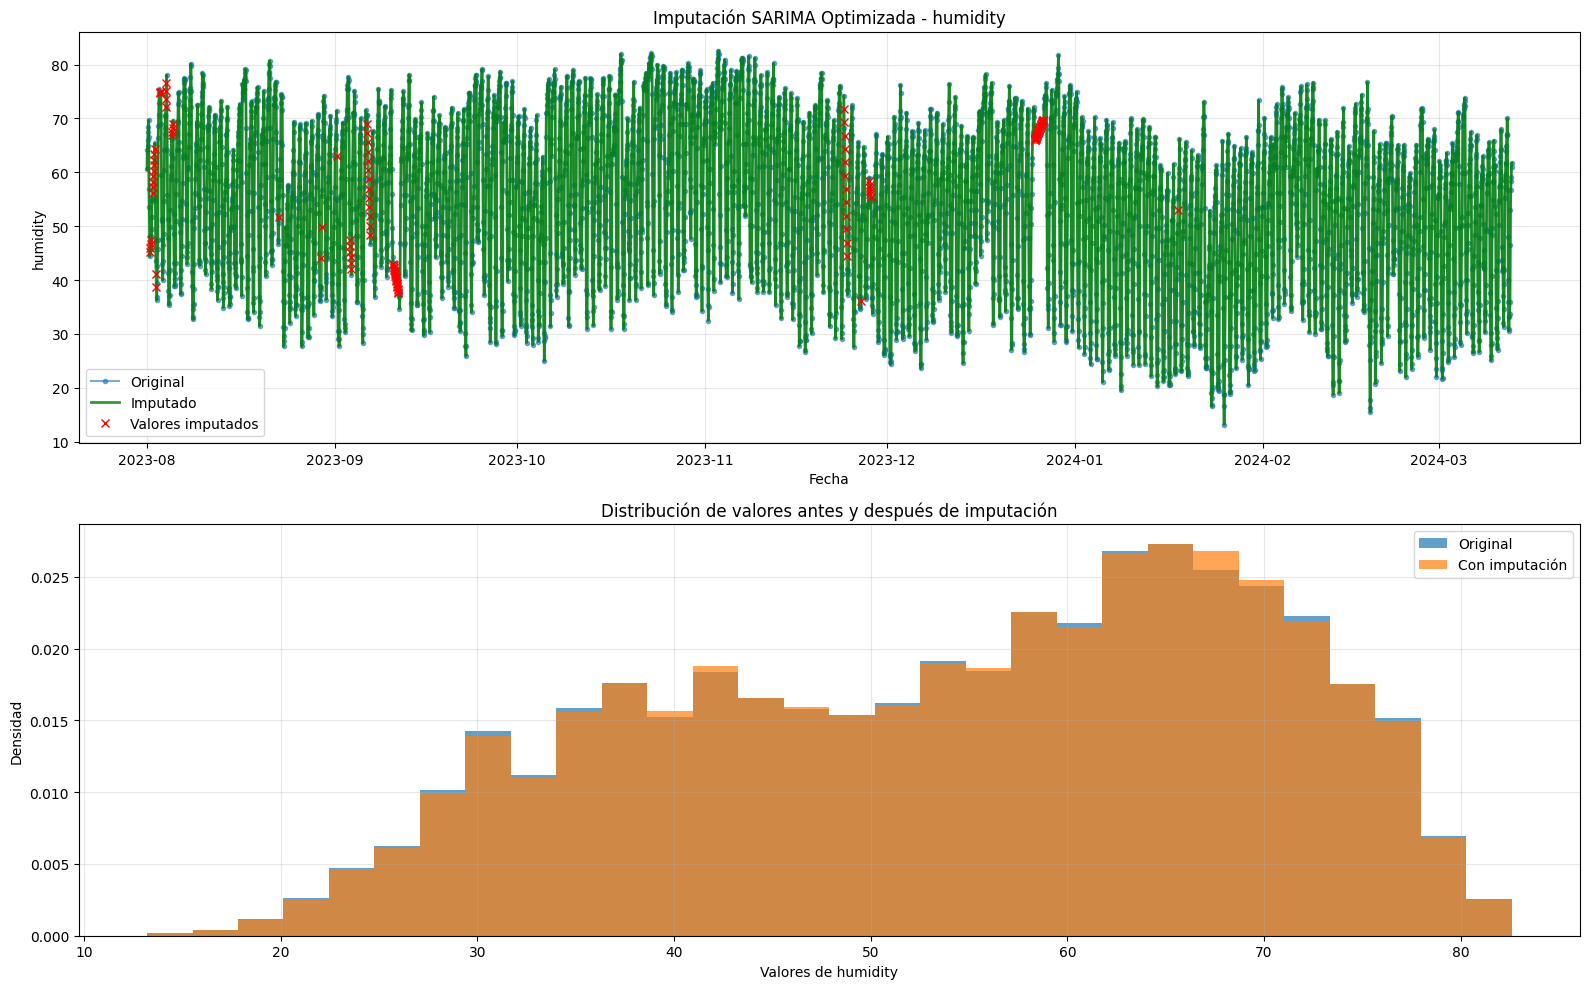

\n=== Resumen de imputación para humidity ===
Valores imputados: 124
Método: SARIMA (1, 1, 1) x (2, 1, 1, 24)
Calidad (RMSE): 2.59


In [62]:
DF_AQ1_FC_IM = imputar_valores_sarima_optimized(DF_AQ1_FC, columna='humidity', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,1,24))

In [63]:
DF_AQ1_FC_IM["df_imputado"].isna().sum()

pm2_5          122
pm10           122
humidity         0
temperature    145
pm5            122
dtype: int64

=== Imputación SARIMA Optimizada para temperature ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 145 (2.7%)
\n--- Paso 1: Detección y remoción de outliers ---
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 33
Imputando secuencia 1/33 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/33 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/33 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/33 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/33 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/33 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/33 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/33 (2 valores)
Error en imputación SARIMAX

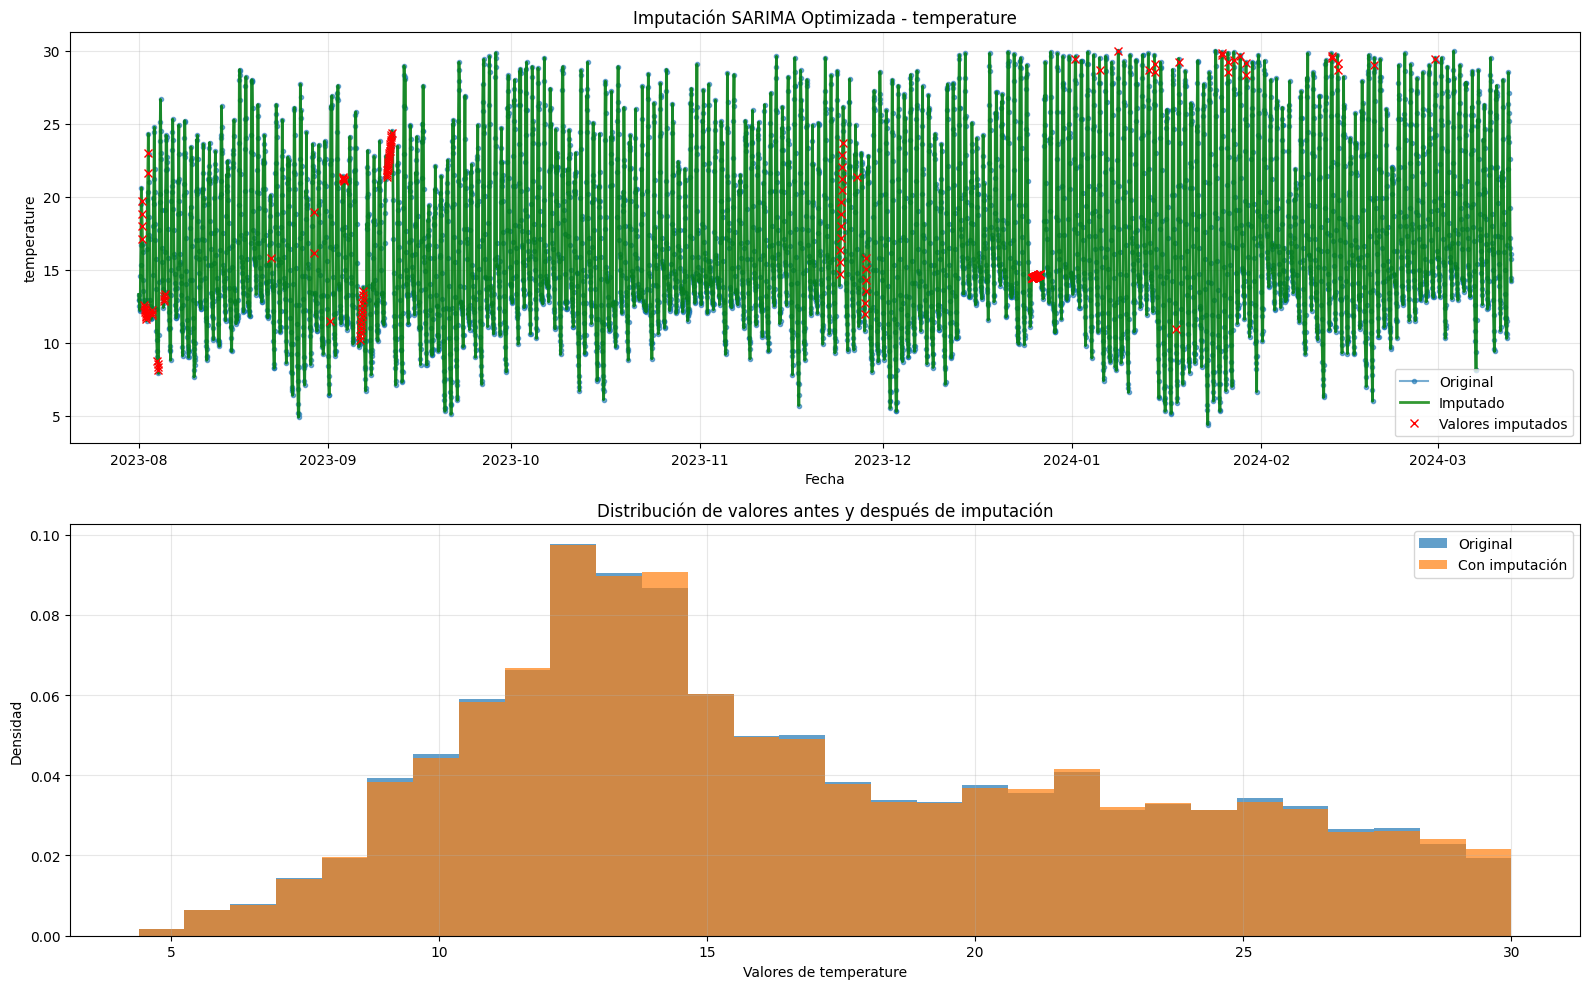

\n=== Resumen de imputación para temperature ===
Valores imputados: 145
Método: SARIMA (1, 1, 1) x (2, 1, 1, 24)
Calidad (RMSE): 1.11


In [64]:
DF_AQ1_FC_IM_2 = imputar_valores_sarima_optimized(DF_AQ1_FC_IM["df_imputado"], columna='temperature', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,1,24))

In [65]:
DF_AQ1_FC_IM_2["df_imputado"].isna().sum()

pm2_5          122
pm10           122
humidity         0
temperature      0
pm5            122
dtype: int64

=== Imputación SARIMA Optimizada para pm5 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 122 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 17
Imputando secuencia 1/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/17 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/17 (1 valores)
Error en imputació

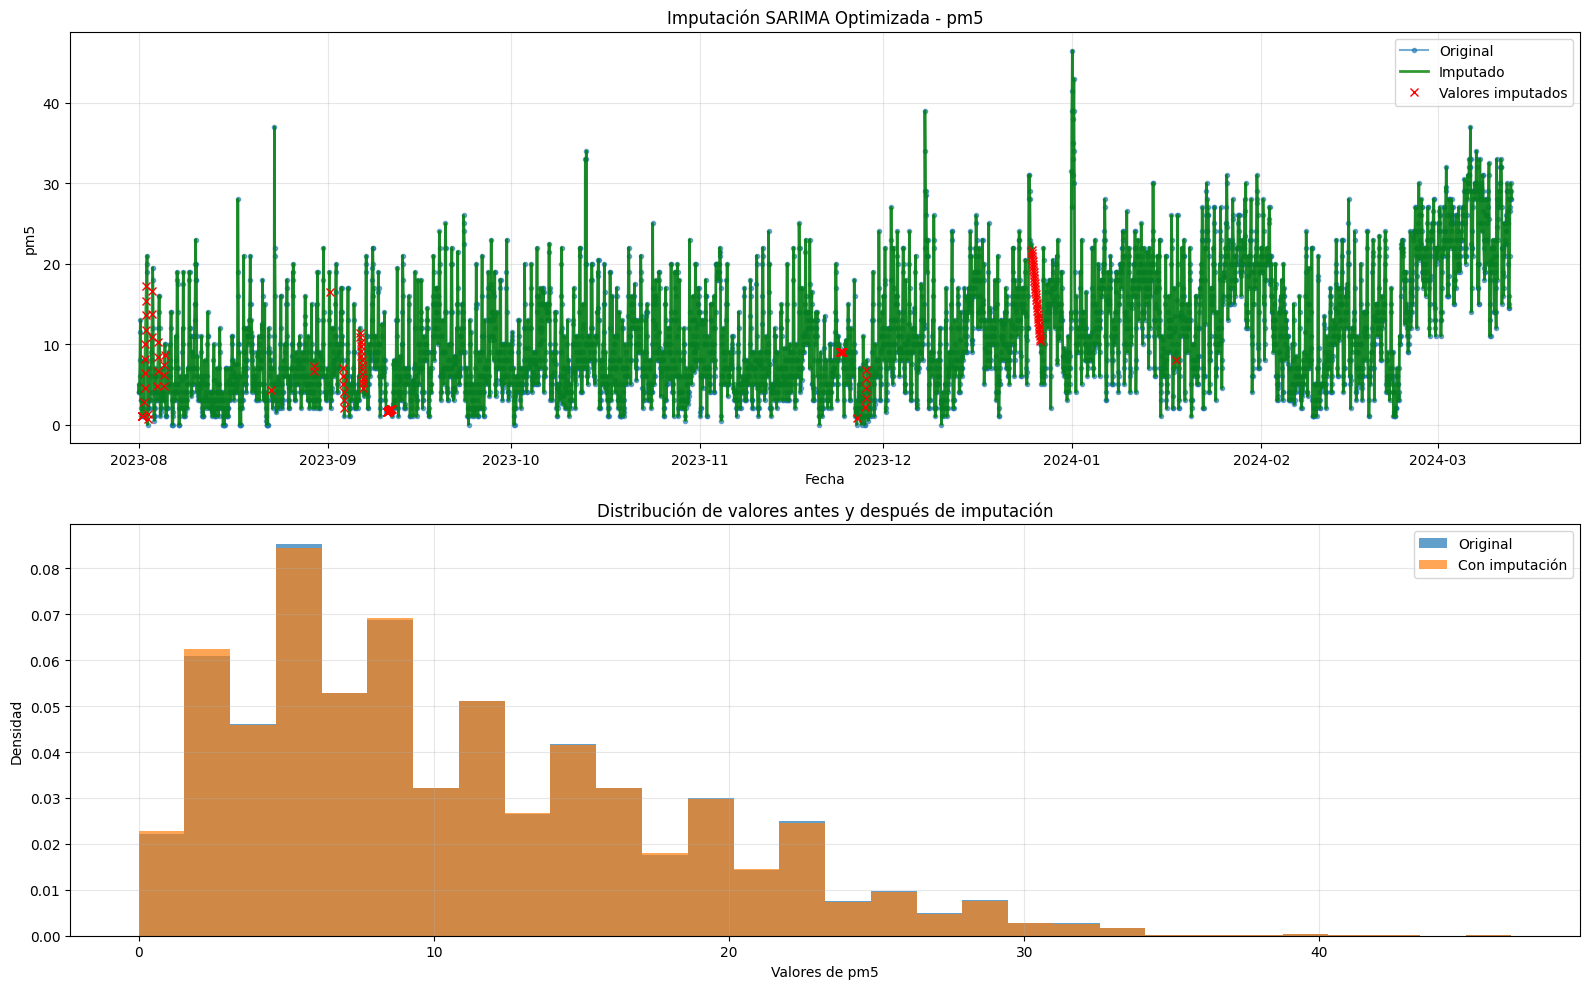

\n=== Resumen de imputación para pm5 ===
Valores imputados: 122
Método: SARIMA (1, 1, 1) x (2, 1, 1, 24)
Calidad (RMSE): 2.39


In [66]:
DF_AQ1_FC_IM_3 = imputar_valores_sarima_optimized(DF_AQ1_FC_IM_2["df_imputado"], columna='pm5', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,1,24), remove_outliers=False)

In [67]:
DF_AQ1_FC_IM_3["df_imputado"].isna().sum()

pm2_5          122
pm10           122
humidity         0
temperature      0
pm5              0
dtype: int64

=== Imputación SARIMA Optimizada para pm10 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 122 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 17
Imputando secuencia 1/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/17 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/17 (1 valores)
Error en imputaci

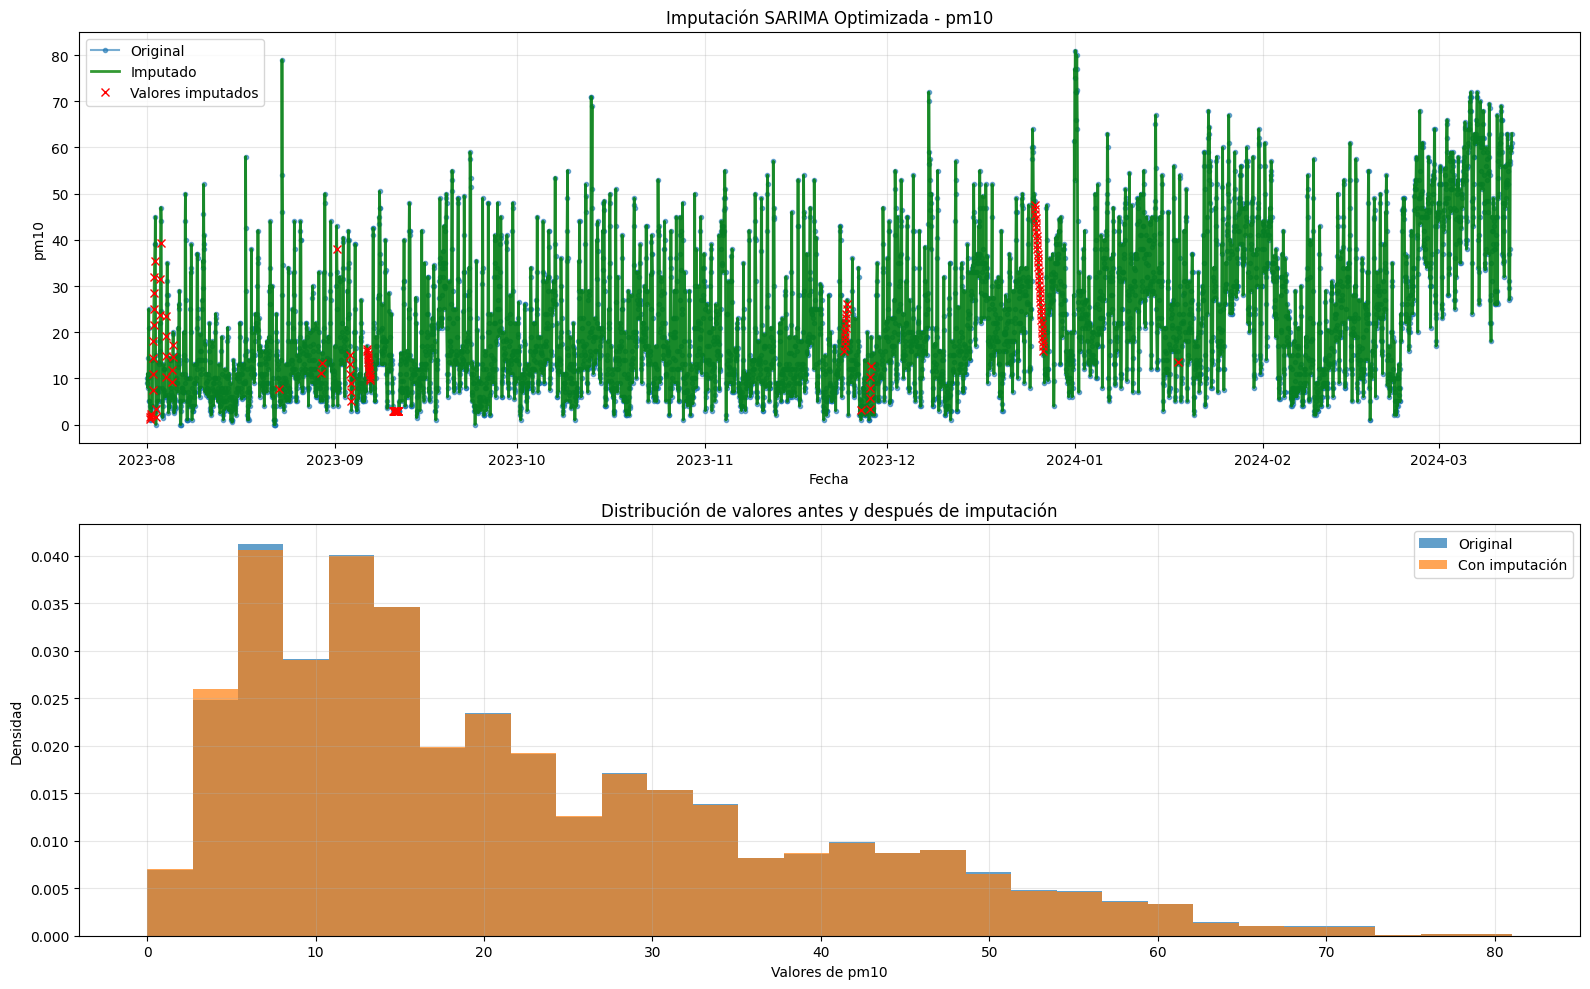

\n=== Resumen de imputación para pm10 ===
Valores imputados: 122
Método: SARIMA (1, 1, 1) x (2, 1, 1, 24)
Calidad (RMSE): 5.97


In [68]:
DF_AQ1_FC_IM_4 = imputar_valores_sarima_optimized(DF_AQ1_FC_IM_3["df_imputado"], columna='pm10', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,1,24), remove_outliers=False)

In [69]:
DF_AQ1_FC_IM_4["df_imputado"].isna().sum()

pm2_5          122
pm10             0
humidity         0
temperature      0
pm5              0
dtype: int64

=== Imputación SARIMA Optimizada para pm2_5 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 122 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 2, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 17
Imputando secuencia 1/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/17 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/17 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/17 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/17 (1 valores)
Error en imputac

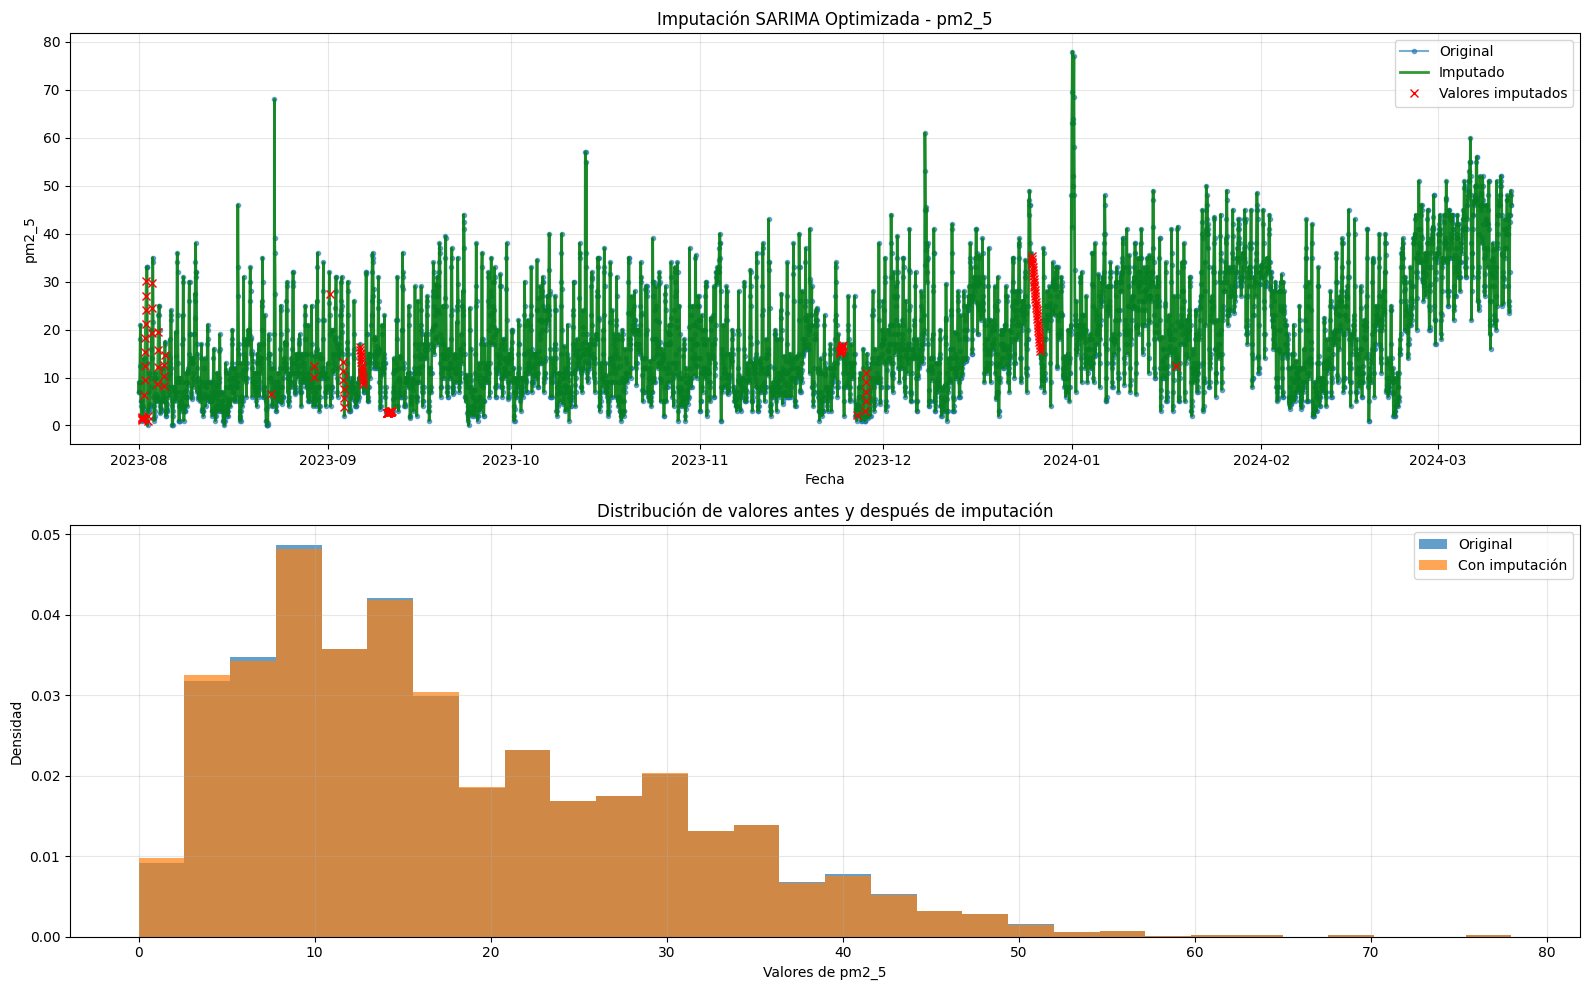

\n=== Resumen de imputación para pm2_5 ===
Valores imputados: 122
Método: SARIMA (1, 1, 1) x (1, 1, 2, 24)
Calidad (RMSE): 4.11


In [80]:
DF_AQ1_FC_IM_5 = imputar_valores_sarima_optimized(DF_AQ1_FC_IM_4["df_imputado"], columna='pm2_5', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,2,24), remove_outliers=False)

In [81]:
DF_AQ1_FC_IM_5["df_imputado"].isna().sum()

pm2_5          0
pm10           0
humidity       0
temperature    0
pm5            0
dtype: int64

In [82]:
DF_AQ1_IM_F = DF_AQ1_FC_IM_5["df_imputado"]

In [83]:
DF_AQ2_F_I = DF_AQ2_FC

=== Imputación SARIMA Optimizada para humidity ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 125 (2.3%)
\n--- Paso 1: Detección y remoción de outliers ---
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 18
Imputando secuencia 1/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/18 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/18 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/18 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/18 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/18 (2 valores)
Error en imputación SARIMAX: 0

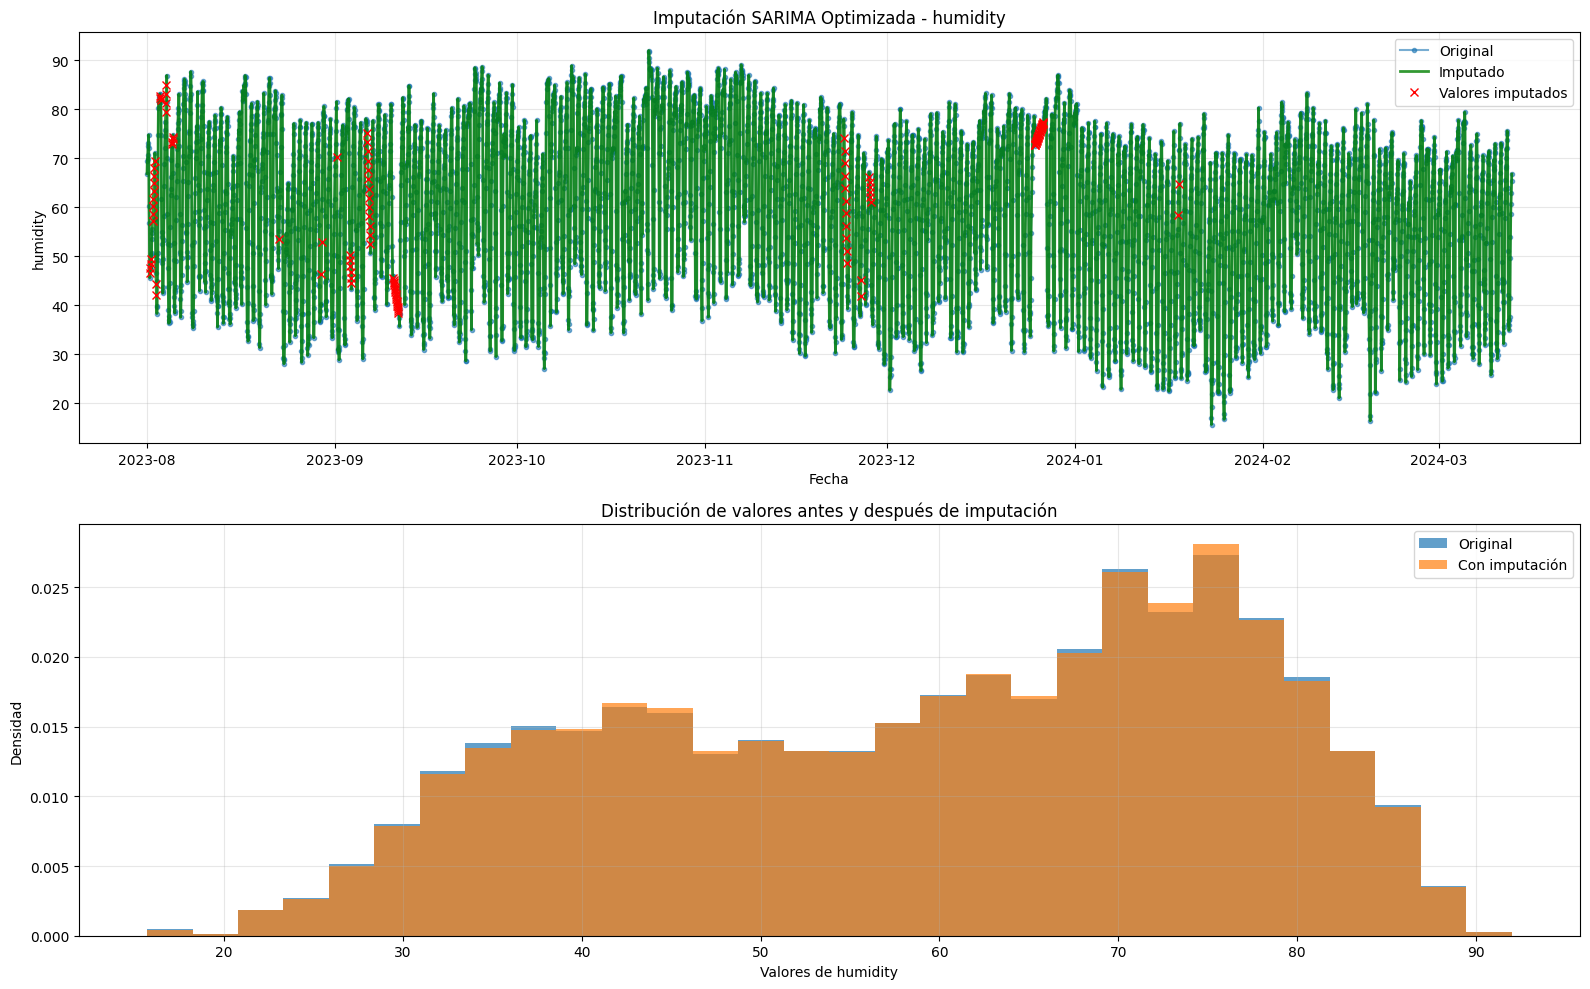

\n=== Resumen de imputación para humidity ===
Valores imputados: 125
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 2.60


In [84]:
DF_AQ2_FC_IM_0 = imputar_valores_sarima_optimized(DF_AQ2_FC, columna='humidity', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24))

=== Imputación SARIMA Optimizada para temperature ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 125 (2.3%)
\n--- Paso 1: Detección y remoción de outliers ---
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 18
Imputando secuencia 1/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/18 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/18 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/18 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/18 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/18 (2 valores)
Error en imputación SARIMAX

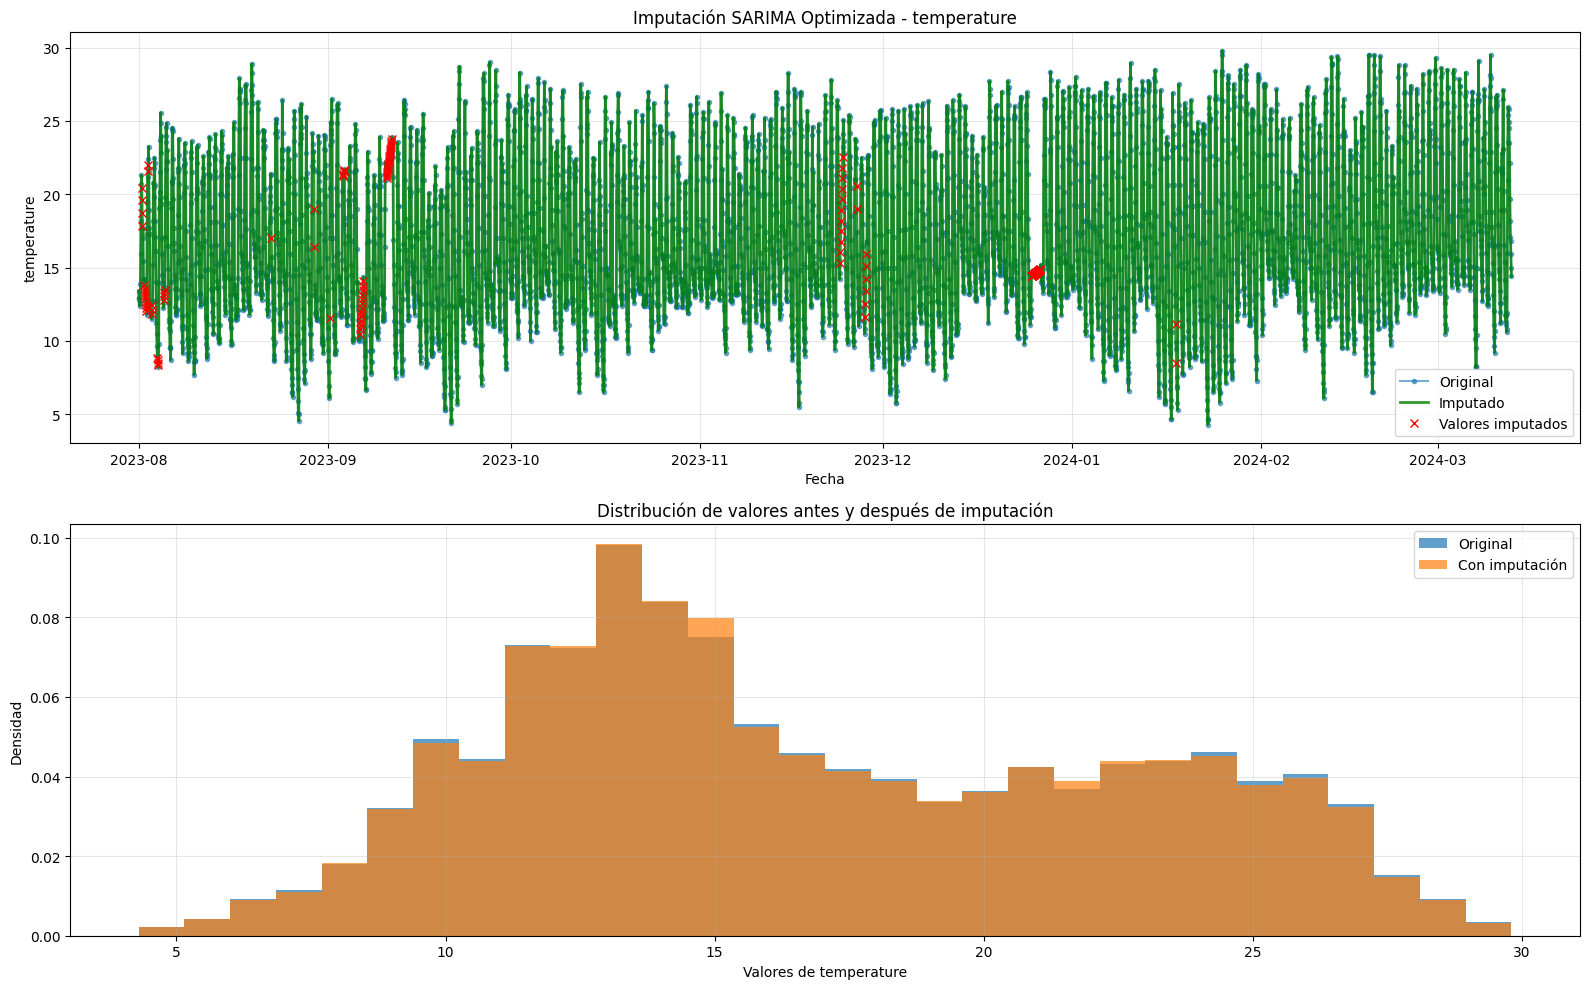

\n=== Resumen de imputación para temperature ===
Valores imputados: 125
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 0.91


In [86]:
DF_AQ2_FC_IM_1 = imputar_valores_sarima_optimized(DF_AQ2_FC_IM_0["df_imputado"], columna='temperature', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24))

=== Imputación SARIMA Optimizada para pm5 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 125 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 19
Imputando secuencia 1/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/19 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/19 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/19 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/19 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/19 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/19 (1 valores)
Error en imputació

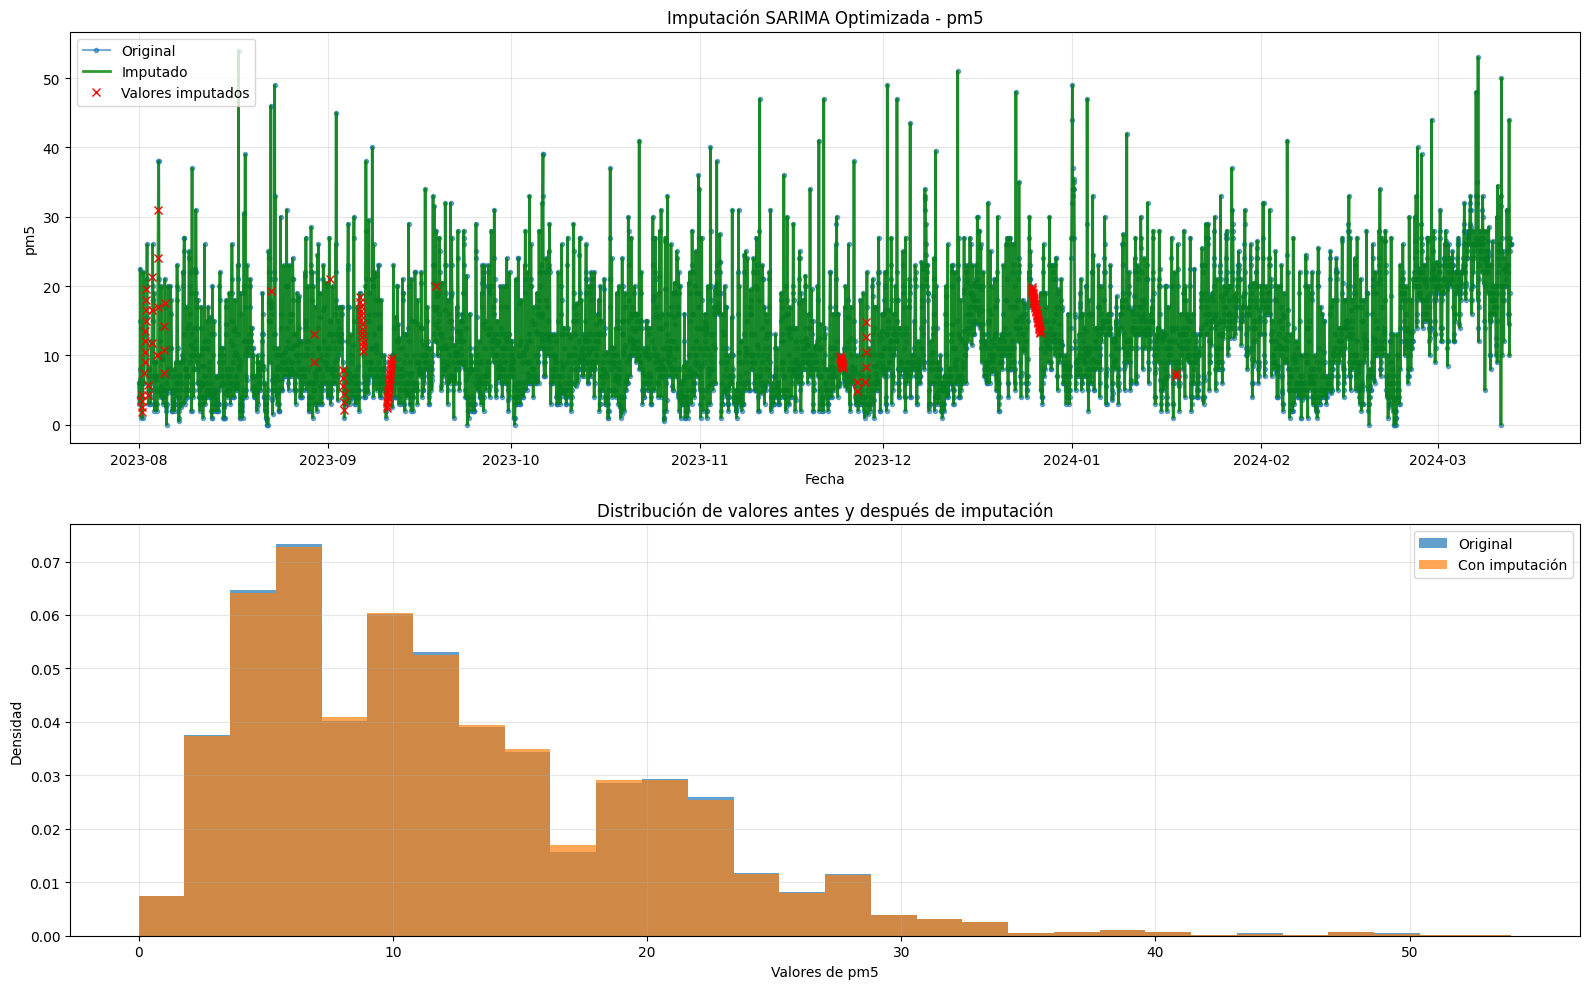

\n=== Resumen de imputación para pm5 ===
Valores imputados: 125
Método: SARIMA (1, 1, 1) x (2, 1, 1, 24)
Calidad (RMSE): 4.98


In [89]:
DF_AQ2_FC_IM_2 = imputar_valores_sarima_optimized(DF_AQ2_FC_IM_1["df_imputado"], columna='pm5', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,1,24), remove_outliers=False)

=== Imputación SARIMA Optimizada para pm10 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 125 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (2, 1, 3, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 19
Imputando secuencia 1/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/19 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/19 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/19 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/19 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/19 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/19 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/19 (1 valores)
Error en imputaci

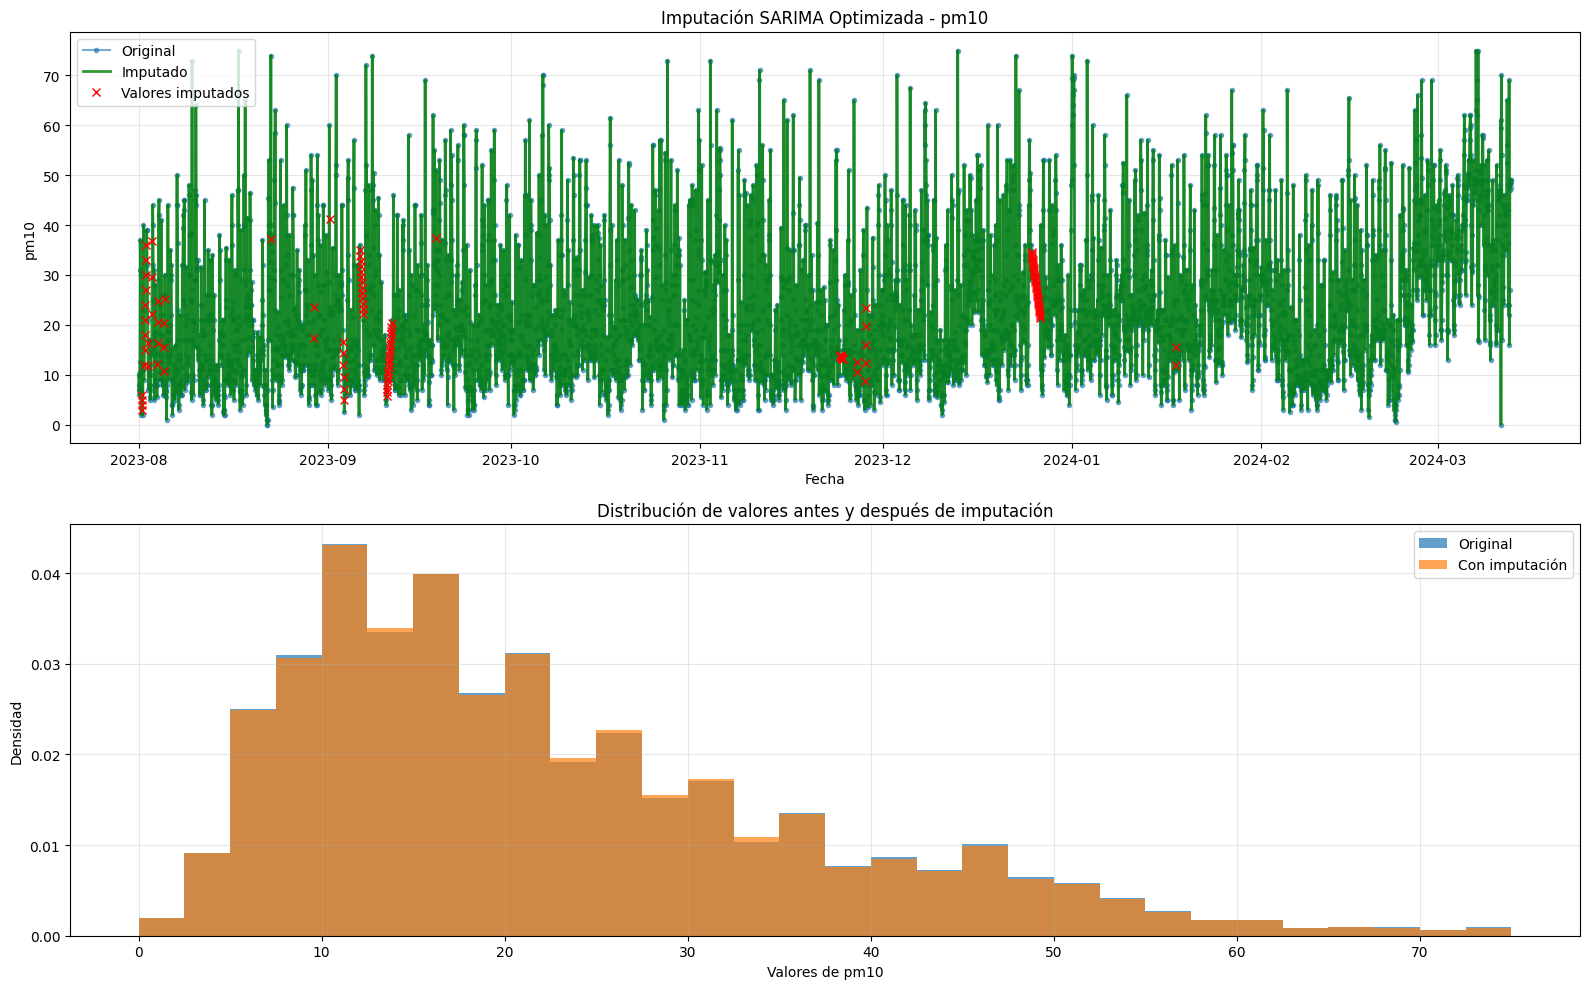

\n=== Resumen de imputación para pm10 ===
Valores imputados: 125
Método: SARIMA (1, 1, 1) x (2, 1, 3, 24)
Calidad (RMSE): 9.14


In [117]:
DF_AQ2_FC_IM_3 = imputar_valores_sarima_optimized(DF_AQ2_FC_IM_2["df_imputado"], columna='pm10', auto_optimize=False,order=(1,1,1),seasonal_order=(2,1,3,24), remove_outliers=False)

=== Imputación SARIMA Optimizada para pm2_5 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 124 (2.3%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 2, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 18
Imputando secuencia 1/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/18 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/18 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/18 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/18 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/18 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/18 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/18 (1 valores)
Error en imputac

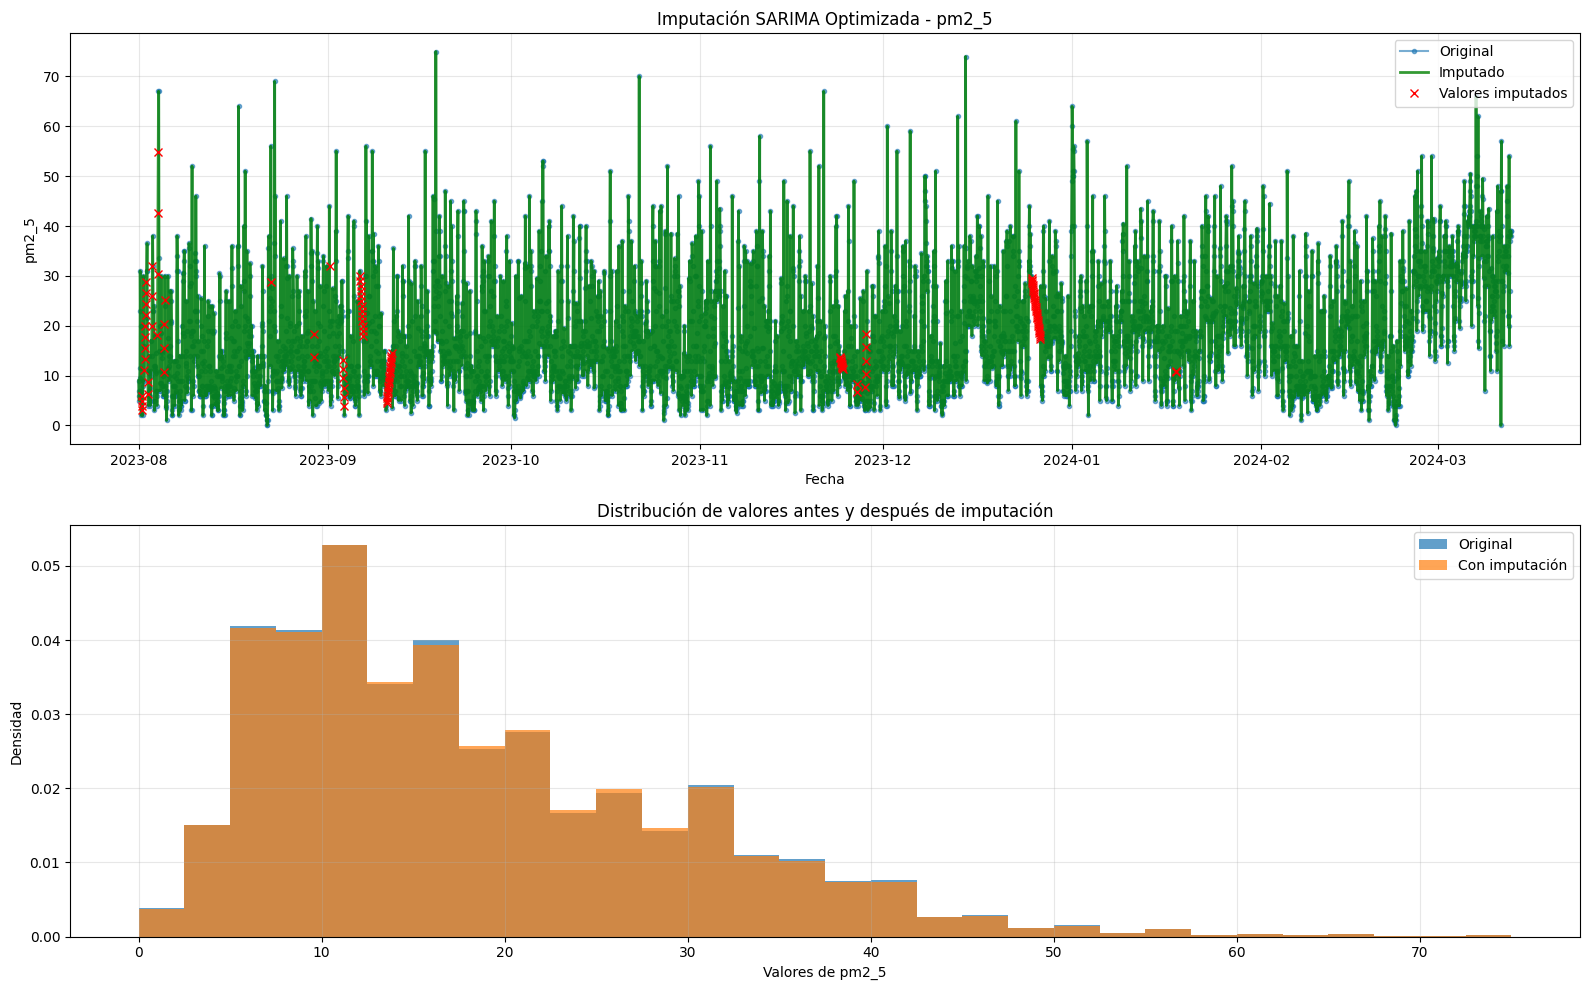

\n=== Resumen de imputación para pm2_5 ===
Valores imputados: 124
Método: SARIMA (1, 1, 1) x (1, 1, 2, 24)
Calidad (RMSE): 6.72


In [97]:
DF_AQ2_FC_IM_4 = imputar_valores_sarima_optimized(DF_AQ2_FC_IM_3["df_imputado"], columna='pm2_5', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,2,24), remove_outliers=False)

In [99]:
DF_AQ2_FC_IM_4["df_imputado"].isna().sum()


pm2_5          0
pm10           0
humidity       0
temperature    0
pm5            0
dtype: int64

In [100]:
DF_AQ2_IM_F = DF_AQ2_FC_IM_4["df_imputado"]

In [103]:
DF_AQSEP_FC_IM_0 = DF_AQSEP_FC

=== Imputación SARIMA Optimizada para pm10 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 216 (4.0%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0012
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 72
Imputando secuencia 1/72 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/72 (10 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/72 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/72 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/72 (6 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/72 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/72 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 8/72 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 9/72 (3 valores)
Error en imputac

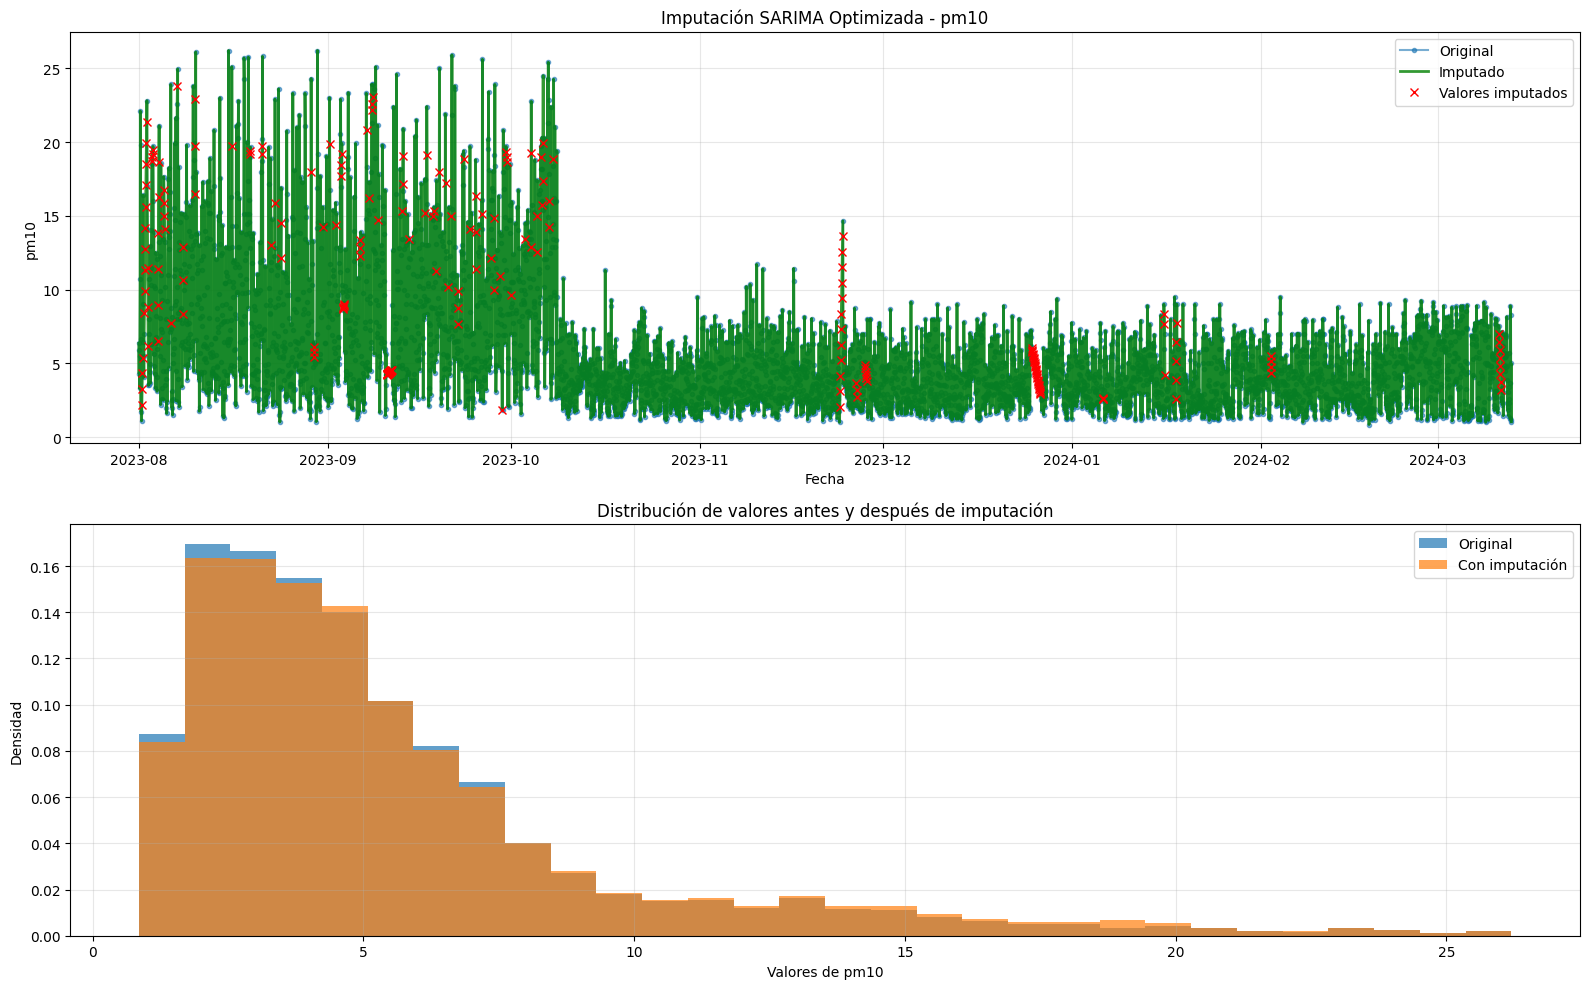

\n=== Resumen de imputación para pm10 ===
Valores imputados: 216
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 3.04
=== Imputación SARIMA Optimizada para pm2_5 ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 193 (3.6%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 52
Imputando secuencia 1/52 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/52 (10 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/52 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/52 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/52 (5 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/52 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/52 (2 valores)
Error en imputación SARI

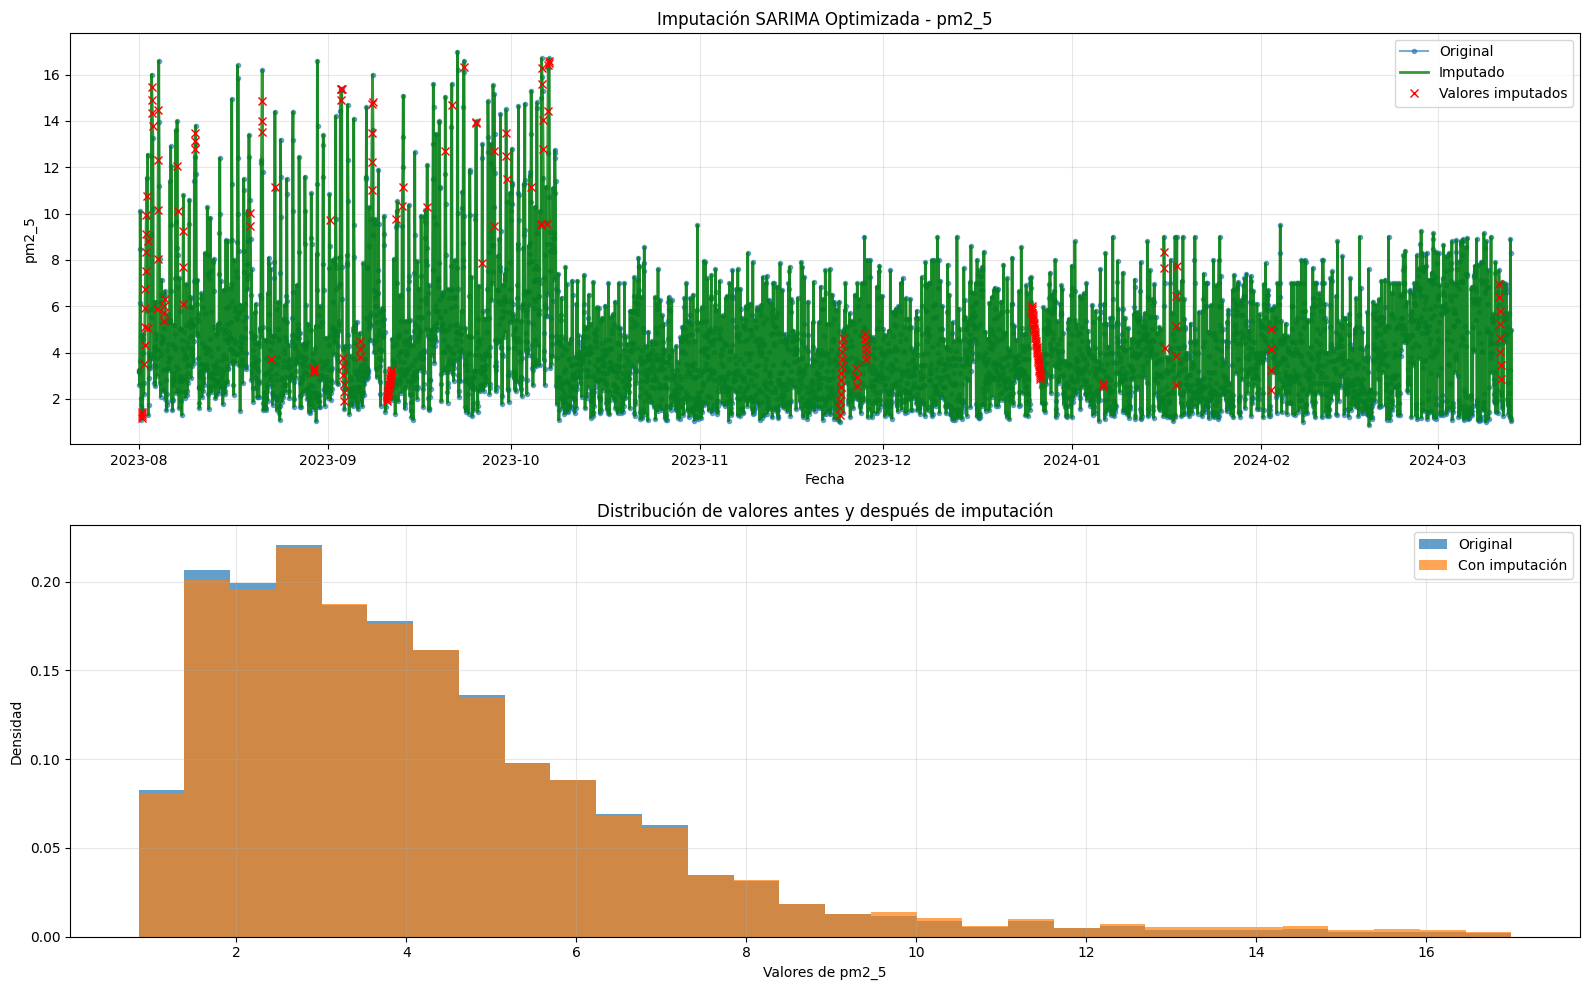

\n=== Resumen de imputación para pm2_5 ===
Valores imputados: 193
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 1.93
=== Imputación SARIMA Optimizada para humidity ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 350 (6.5%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 17
Imputando secuencia 1/17 (236 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/17 (1 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/17 (6 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/17 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/17 (21 valores)
Error en imputació

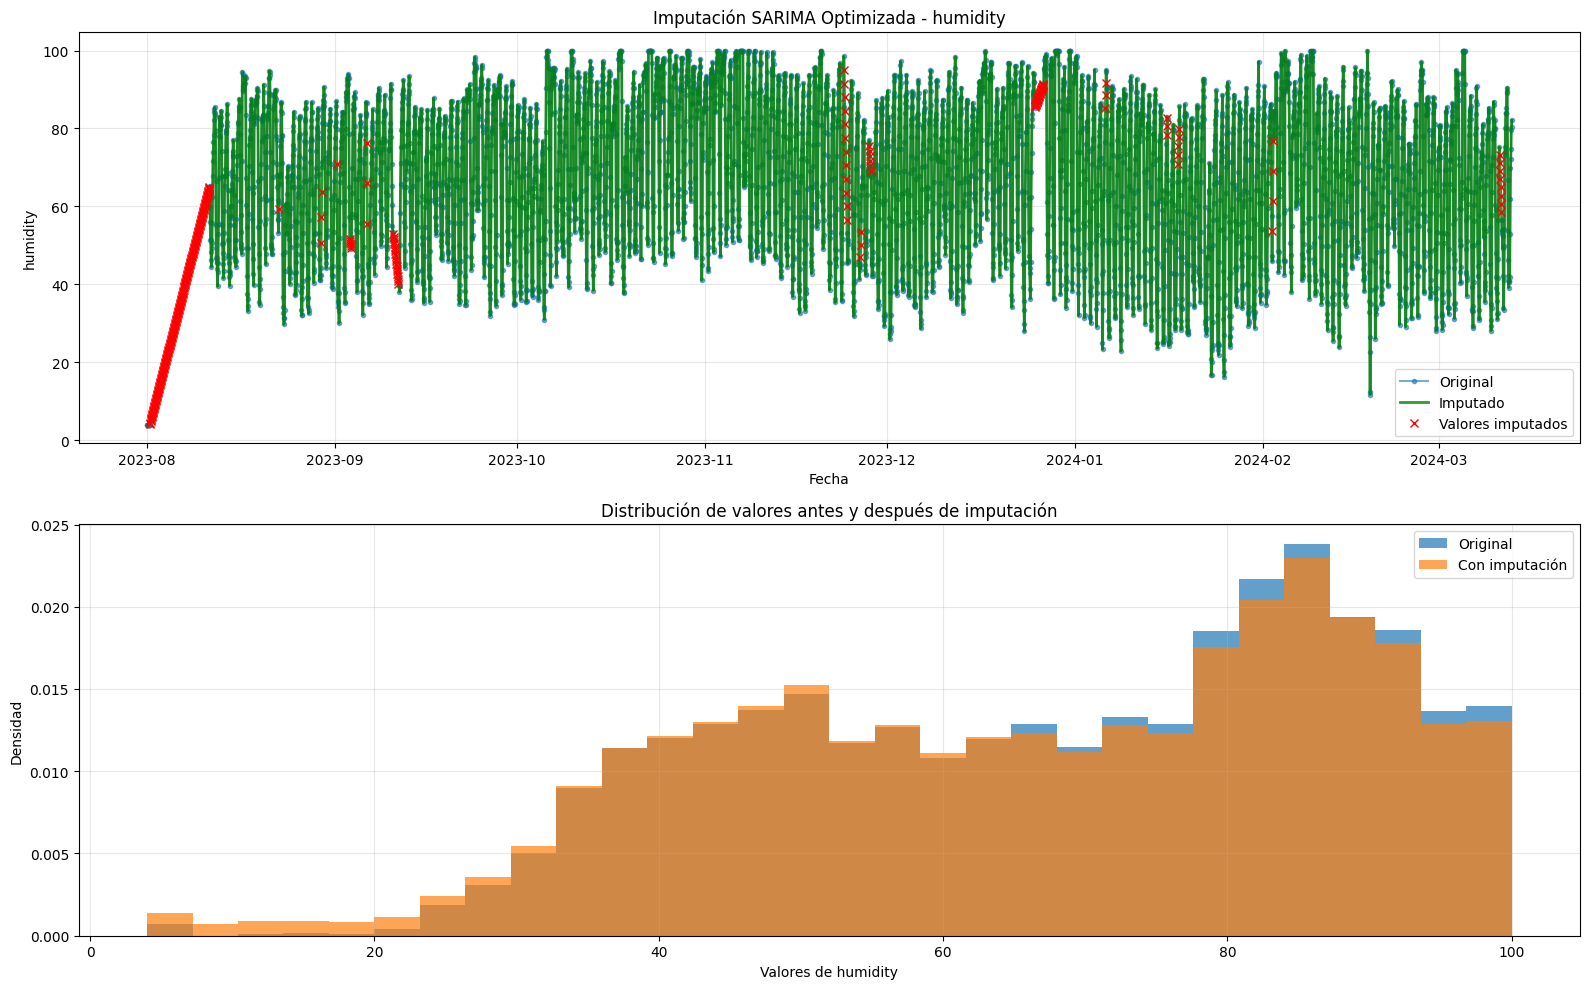

\n=== Resumen de imputación para humidity ===
Valores imputados: 350
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 3.89
=== Imputación SARIMA Optimizada para temperature ===
📊 Sin variables exógenas especificadas
Total de valores: 5401
Valores faltantes: 140 (2.6%)
\n--- Paso 2: Análisis de estacionariedad ---
Resultado del test ADF: Estacionaria
p-value: 0.0000
\n--- Paso 3: Usando parámetros especificados ---
Parámetros: (1, 1, 1) x (1, 1, 1, 24)
\n--- Paso 4: Imputación de valores ---
Secuencias de valores faltantes: 22
Imputando secuencia 1/22 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 2/22 (9 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 3/22 (2 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 4/22 (3 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 5/22 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 6/22 (4 valores)
Error en imputación SARIMAX: 0
Imputando secuencia 7/22 (1 valores)
Error en imputa

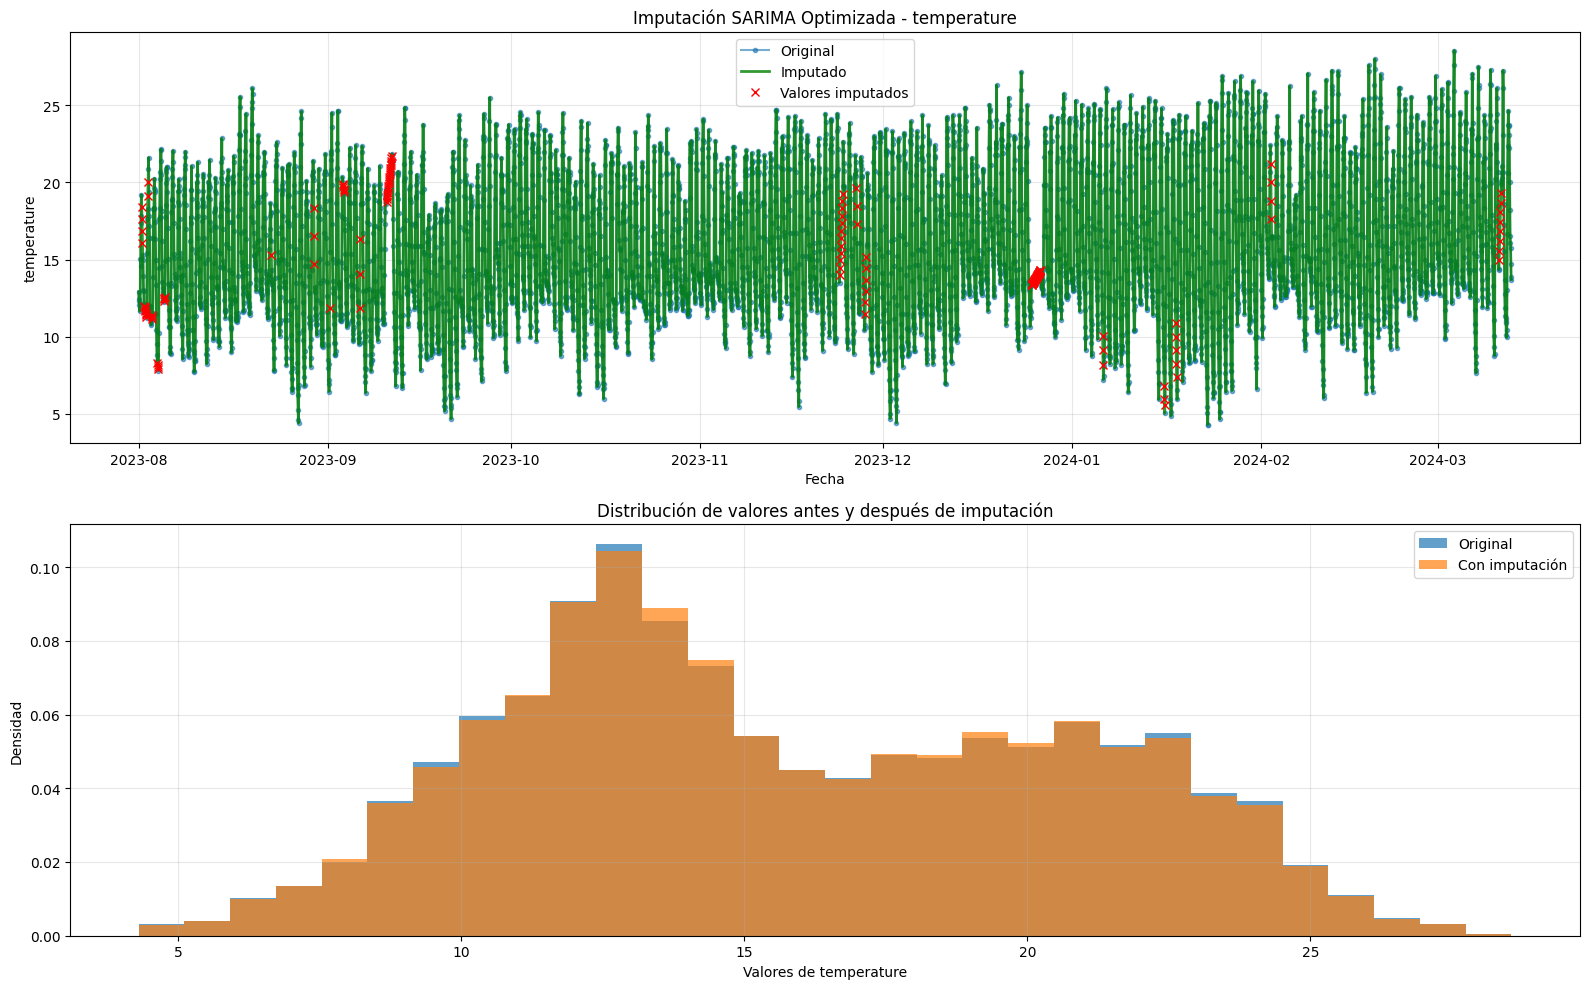

\n=== Resumen de imputación para temperature ===
Valores imputados: 140
Método: SARIMA (1, 1, 1) x (1, 1, 1, 24)
Calidad (RMSE): 0.86


In [106]:
import warnings

# Ocultar warnings específicos por mensaje o categoría:
warnings.filterwarnings("ignore", message="No supported index is available")
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", category=FutureWarning)

#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_FC,columna='pm10',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_F_I,columna='pm2_5',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_F_I,columna='humidity',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_F_I,columna='temperature',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_F_I,columna='co',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)
#DF_AQSEP_F_I = imputar_valores_sarima(DF_AQSEP_F_I,columna='o3',order=(2, 0, 1),seasonal_order=(0, 0, 0, 24),plot=True)

DF_AQSEP_FC_IM_1 = imputar_valores_sarima_optimized(DF_AQSEP_FC_IM_0, columna='pm10', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24), remove_outliers=False)

DF_AQSEP_FC_IM_2 = imputar_valores_sarima_optimized(DF_AQSEP_FC_IM_1['df_imputado'], columna='pm2_5', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24), remove_outliers=False)

DF_AQSEP_FC_IM_3 = imputar_valores_sarima_optimized(DF_AQSEP_FC_IM_2['df_imputado'], columna='humidity', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24), remove_outliers=False)

DF_AQSEP_FC_IM_4 = imputar_valores_sarima_optimized(DF_AQSEP_FC_IM_3['df_imputado'], columna='temperature', auto_optimize=False,order=(1,1,1),seasonal_order=(1,1,1,24), remove_outliers=False)
DF_AQSEP_IM_F = DF_AQSEP_FC_IM_4['df_imputado']

In [107]:
DF_AQSEP_IM_F.isna().sum()

pm2_5             0
pm10              0
pm5            5401
humidity          0
temperature       0
dtype: int64

In [108]:
DF_AQSEP_IM_F = DF_AQSEP_IM_F

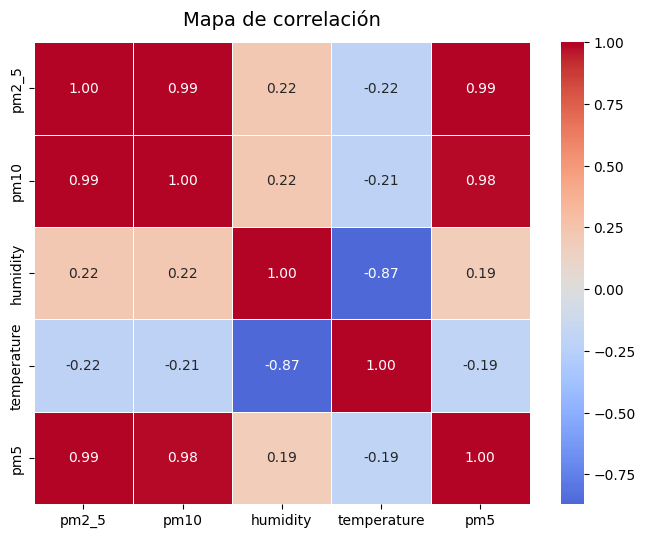

In [110]:
plot_correlation_map(DF_AQ1_F_I)

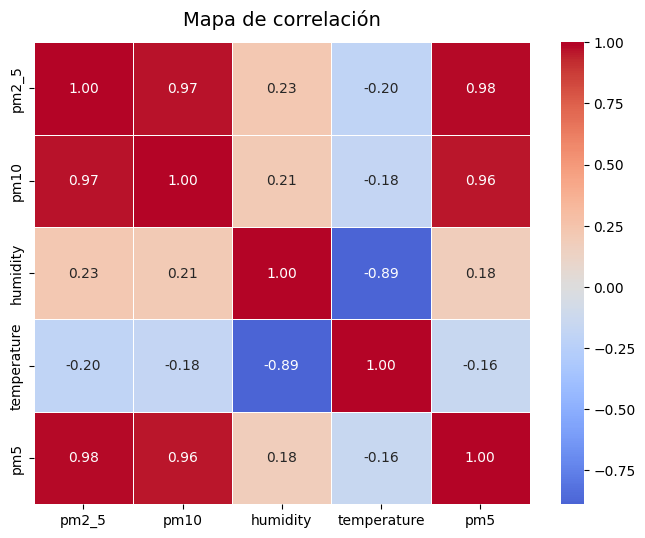

In [111]:
plot_correlation_map(DF_AQ2_IM_F)

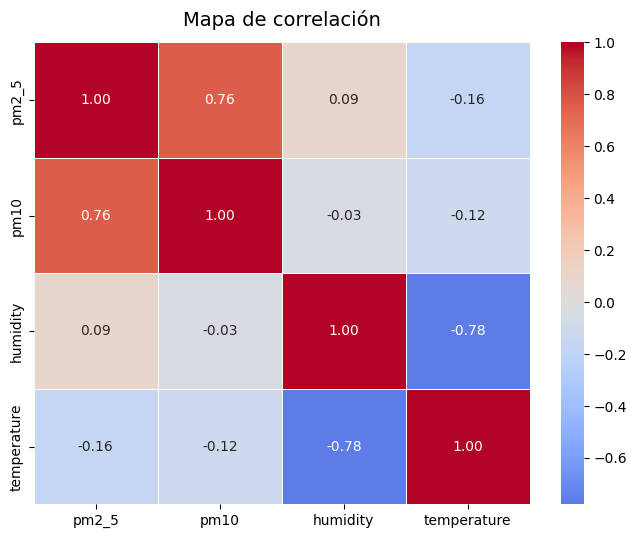

In [112]:
plot_correlation_map(DF_AQSEP_IM_F)

In [113]:
def create_and_insert_resampled_tables(dataframes_dict):
    """
    Crea tablas en la base de datos si no existen y luego inserta los datos resampleados.

    Parámetros:
        dataframes_dict (dict): Diccionario con clave como nombre de la tabla y valor el DataFrame

    Retorna:
        None
    """
    if engine is None:
        raise Exception("⚠️ Debes ejecutar primero `connect_to_db()` para establecer la conexión.")

    inspector = inspect(engine)

    for table_name, df in dataframes_dict.items():
        try:
            # Verificar si la tabla ya existe
            if table_name in inspector.get_table_names():
                print(f"ℹ️ La tabla '{table_name}' ya existe. No se creó ni sobrescribió.")
            else:
                # Crear tabla e insertar datos
                df.to_sql(name=table_name, con=engine, if_exists='fail', index=True)
                print(f"✅ Tabla '{table_name}' creada y datos insertados ({len(df)} registros).")
        except Exception as e:
            print(f"❌ Error en la tabla '{table_name}': {e}")


In [114]:
resampled_dfs = {
    "DF_AQ2_IMPUTED": DF_AQ2_IM_F,
    "DF_AQ1_IMPUTED": DF_AQ1_IM_F,
    "DF_AQSEP_IMPUTED": DF_AQSEP_IM_F
}

create_and_insert_resampled_tables(resampled_dfs)


✅ Tabla 'DF_AQ2_IMPUTED' creada y datos insertados (5401 registros).
✅ Tabla 'DF_AQ1_IMPUTED' creada y datos insertados (5401 registros).
✅ Tabla 'DF_AQSEP_IMPUTED' creada y datos insertados (5401 registros).
